# OMR Music Sheet to A MP3 file


In [394]:
import skimage.io as io
from skimage import img_as_ubyte
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.exposure import histogram
from skimage.filters import threshold_otsu,threshold_local,median, unsharp_mask, gaussian
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv
from commonfunctions import *
from scipy.ndimage import rotate
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin, binary_opening, remove_small_objects
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.transform import resize
from scipy.stats import mode



In [395]:
def show_images(images,titles=None):
    def show_images(images, titles=None):
        """
        Display a list of images with optional titles.

        Parameters:
        images (list of ndarray): A list of images to be displayed.
        titles (list of str, optional): A list of titles corresponding to each image. 
                                        If not provided, default titles will be used.

        Returns:
        None
        """
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [396]:
def histogram_equation(image):
    """
    Computes the histogram of an image.

    Parameters:
    image (numpy.ndarray): The input image as a 2D numpy array.

    Returns:
    numpy.ndarray: A 1D numpy array of length 256 representing the histogram of the image.
    """
    shape=image.shape
    H=np.zeros(256)
    for x in range(0,shape[0]):
        for y in range(0,shape[1]):
            H[image[x][y]]+=1

    return H


# def getThresholdRawan(img):
#     counts, _ = np.histogram(img, bins=256, range=(0, 256))
    
#     total_pixels = np.sum(counts)
#     print(total_pixels)
#     Tinit = int(round(np.sum([i * counts[i] for i in range(256)]) / total_pixels))

    
#     while True:
#         if np.sum(counts[:Tinit]) == 0 or np.sum(counts[Tinit:]) == 0:
#             return Tinit
#         lower = np.sum([i * counts[i] for i in range(Tinit)]) / np.sum(counts[:Tinit])
#         higher = np.sum([i * counts[i] for i in range(Tinit, 256)]) / np.sum(counts[Tinit:])
#         new_T = int((lower + higher) / 2)
#         if new_T == Tinit:
#             return new_T
#         Tinit = new_T

# def partition_imageRawan(img, n_partitions_horiz, n_partitions_vert):
#     print(img.shape)
#     height, width = img.shape
#     row_step = height // n_partitions_horiz
#     col_step = width // n_partitions_vert
    
#     binary_img = np.zeros_like(img)
    
#     for i in range(n_partitions_horiz):
#         for j in range(n_partitions_vert):
#             row_start = i * row_step
#             row_end = (i + 1) * row_step if i < n_partitions_horiz - 1 else height
#             col_start = j * col_step
#             col_end = (j + 1) * col_step if j < n_partitions_vert - 1 else width
            
#             img_section = img[row_start:row_end, col_start:col_end]
#             threshold = getThresholdRawan(img_section)
#             binary_section = img_section > threshold
#             binary_img[row_start:row_end, col_start:col_end] = binary_section
            
#     return binary_img


In [397]:
# def getThreshold(image):
#     # image = (image * 255).astype('uint8')

#     counts, _ = np.histogram(image, bins=256, range=(0, 256))
    
#     total_pixels = counts.sum()
#     gray_levels = np.arange(256)
#     Tinit = round((gray_levels * counts).sum() / total_pixels) 
    
#     while True:
#         lower_pixels = counts[:Tinit]
#         upper_pixels = counts[Tinit:]
        
#         if lower_pixels.sum() == 0 or upper_pixels.sum() == 0:
#             break

#         lower_mean = (gray_levels[:Tinit] * lower_pixels).sum() / lower_pixels.sum()
#         upper_mean = (gray_levels[Tinit:] * upper_pixels).sum() / upper_pixels.sum()

#         new_threshold = round((lower_mean + upper_mean) / 2)
        
#         if new_threshold == Tinit:
#             break
        
#         Tinit = new_threshold
    
#     binary_image = np.where(image < Tinit, 0, 255) # 0 is black, 255 is white
#     return binary_image


# def adaptive (image, NumberOfDivisions):
#     new_image = np.array_split(image, NumberOfDivisions, axis=1)
#     thresholded_images = []
#     for imagee in new_image:
#         threshold = getThreshold(imagee)
#         thresholded_images.append(threshold)    
    
#     combined_image = np.block(thresholded_images)

#     return combined_image

In [398]:
# #Testing
# def deskew(original_img):
#     img = np.copy((original_img))
#     # Canny
#     imgCanny = sk.feature.canny(img, sigma=1.5)
#     thresh = sk.filters.threshold_otsu(imgCanny)
#     imgCanny = (imgCanny >= thresh)

#     # Apply Hough Transform
#     # Generates a list of 360 Radian degrees (-pi/2, pi/2)
#     angleSet = np.linspace(-np.pi, np.pi, 1440)
#     houghArr, theta, dis = sk.transform.hough_line(imgCanny, angleSet)

#     flatIdx = np.argmax(houghArr)
#     bestTheta = (flatIdx % theta.shape[0])
#     bestTheta = angleSet[bestTheta]
#     bestDis = np.int32(np.floor(flatIdx / theta.shape[0]))
#     bestDis = dis[bestDis]

#     # Rotate
#     thetaRotateDeg = (bestTheta*180)/np.pi
#     if thetaRotateDeg > 0:
#         thetaRotateDeg = thetaRotateDeg - 90
#     else:
#         thetaRotateDeg = thetaRotateDeg + 90

#     imgRotated = (sk.transform.rotate(
#         img, thetaRotateDeg, resize=True, mode='constant', cval=1))
#     return imgRotated

# def binarize(img, block_size=101):
#     t = sk.filters.threshold_local(img, block_size, offset=10)
#     img_b = img < t
#     return img_b



# def convertImgToUINT8(img_o):
#     img = np.copy(img_o)
#     img = img.astype(np.float64) / np.max(img)
#     img = 255 * img
#     img = img.astype(np.uint8)
#     return img



# img = io.imread("./images/image2.png",as_gray=True)
# if img.shape[0] > 1000 or img.shape[1] > 2000:
#         img = sk.transform.resize(img, (img.shape[0]//4, img.shape[1]//4))
# img1=deskew(img)
# img2 = convertImgToUINT8(img1)
# img3=binarize(img2)
# show_images([img3])

In [399]:
# img = io.imread("./images/image.png",as_gray=True)
# print(img.shape)
# # 1. Binarization

# # # Compute Otsu's threshold
# # otsu_threshold = threshold_otsu(img)
# # binary_image_ski = img > otsu_threshold

# #Adaptive ski
# # # Compute a local threshold
# # block_size = 201  # Size of the local region to consider
# # local_thresh = threshold_local(img, block_size, offset=0)

# #our threshold
# # print(img)
# # threshold=getThreshold(img)
# # img[img>threshold]=1
# # img[img<=threshold]=0

# show_images([img])

In [400]:
def dynamic_binarization(input_image):
    """
    Perform dynamic binarization on the input image based on its histogram characteristics.
    The function first calculates and normalizes the histogram of the input image. It then checks 
    if the histogram has significant peaks near 0 and 255 to determine if the image is likely scanned. 
    Depending on the histogram analysis, it applies either Otsu's binarization or a combination of 
    Otsu's and Adaptive Thresholding to binarize the image.
    Parameters:
    input_image (numpy.ndarray): The input grayscale image to be binarized.
    Returns:
    numpy.ndarray: The binarized image.
    """
    # Calculate the histogram of the input image
    hist = cv2.calcHist([input_image], [0], None, [256], [0, 256])
    # Normalize the histogram for easier analysis
    normalized_hist = hist / hist.sum()
    
    # Check if the histogram has significant peaks near 0 and 255
    near_zero = normalized_hist[:20].sum()  # Sum of bins near 0
    near_255 = normalized_hist[-20:].sum()  # Sum of bins near 255

    # Thresholds for determining scanned images
    if near_zero+near_255 > 0.75:
        # Use Otsu's binarization for scanned images
        _, binarized_image = cv2.threshold(input_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        # Apply both Otsu and Adaptive Thresholding
        _, otsu_binary = cv2.threshold(input_image, 0, 255,cv2.THRESH_BINARY+ cv2.THRESH_OTSU)
        adaptive_binary = cv2.adaptiveThreshold(input_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                cv2.THRESH_BINARY, blockSize=51, C=5)
        
        # Calculate the number of black pixels for Otsu's output
        otsu_black_pixels = np.sum(otsu_binary == 0)

        # Threshold for deciding noise
        noise_threshold = np.sum(hist[:120])

        if otsu_black_pixels > noise_threshold:
            # Otsu produces noise, use Adaptive Thresholding
            binarized_image = adaptive_binary
        else:
            # Otsu works fine
            binarized_image = otsu_binary

    return binarized_image

In [401]:

def resize_with_aspect_ratio(image, target_width, target_height, color=0):
    """
    Resize an image while maintaining its aspect ratio and place it on a canvas of target dimensions.
    Parameters:
    image (numpy.ndarray): The input image to be resized.
    target_width (int): The width of the target canvas.
    target_height (int): The height of the target canvas.
    color (int, optional): The color value to fill the canvas background. Default is 0 (black).
    Returns:
    numpy.ndarray: The resized image placed on a canvas of target dimensions.
    """
    # Get original dimensions
    h, w = image.shape[:2]
    
    # Calculate the scaling factor to maintain aspect ratio
    scale = min(target_width / w, target_height / h)
    
    # Compute the new dimensions
    new_width = int(w * scale)
    new_height = int(h * scale)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Create a new blank image with the target dimensions
    canvas =np.full((target_height, target_width), color, dtype=np.uint8)
    
    # Calculate padding to center the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Place the resized image onto the canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image
    
    return canvas


In [402]:
def rotate_image (binarized_image,lines):
    def rotate_image(binarized_image, lines):
        """
        Rotates the given binarized image based on the detected lines' angles.

        Parameters:
        binarized_image (numpy.ndarray): The binarized image to be rotated.
        lines (list): A list of lines detected in the image. Each line is represented by a tuple (rho, theta).

        Returns:
        numpy.ndarray: The rotated image if rotation is needed, otherwise the original image.

        The function performs the following steps:
        1. Checks if lines are detected.
        2. Calculates the angles of the detected lines.
        3. Determines if the majority of lines are horizontal (angle close to 0°).
        4. If the majority of lines are not horizontal, calculates the mode of the angles and rotates the image accordingly.
        5. Returns the rotated image or the original image if no rotation is needed.
        """
    rotated_image= binarized_image
    if lines is not None:  # Found lines
        angles = []  # Store the angles of the detected lines
        zero_angle_count = 0  # Count lines with angles close to 0°
        tolerance_zero = 2.0  # Tolerance to consider an angle as 0° (degrees)

        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))  # Endpoint 1
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))  # Endpoint 2
            y2 = int(y0 - 1000 * (a))

            # Convert angle to degrees
            angle_degrees = 180 * theta / np.pi
            angles.append(angle_degrees)

            # Check if angle is close to 0° (horizontal line)
            if abs(angle_degrees) < tolerance_zero or abs(angle_degrees - 180) < tolerance_zero:
                zero_angle_count += 1

        # Majority Check: If most lines are at zero angles, skip rotation
        if zero_angle_count > len(angles) / 2:  # Majority condition
            print("Majority of lines are horizontal. Skipping rotation.")
        else:
            # Calculate the average angle excluding near-zero angles
            # average_angle = np.mean([angle for angle in angles if abs(angle) > tolerance_zero])
            mode_angle, _ = mode([angle for angle in angles if abs(angle) > tolerance_zero], axis= 0)
            print("mode result", mode_angle)
            if abs(mode_angle)>2:
                rotated_image = rotate(rotated_image, mode_angle - 90, cval=255)

    else:
        print("No lines found")

    return rotated_image

In [403]:
def convert_to_bool_reverse(image):
    """
    Convert an image to its boolean reverse.

    This function takes an image, inverts its pixel values, and then converts 
    the image to a boolean array where all non-zero values are set to True.

    Parameters:
    image (numpy.ndarray): The input image array.

    Returns:
    numpy.ndarray: The boolean array of the inverted image.
    """
    image=255-image
    image=image>0
    return image


In [404]:
def getBoundedBoxes(image):
    """
    Parameters:
    image (numpy.ndarray): A binary image where the staves are to be detected.
    Returns:
    list: A list of binary images, each containing a detected stave.
    The function performs the following steps:
    1. Removes small objects from the binary image to clean up noise.
    2. Dilates the image vertically to connect staff lines.
    3. Optionally shows intermediate results for debugging purposes.
    4. Crops a portion of the image to exclude the beginning.
    5. Converts binary images to uint8 format for contour detection.
    6. Finds contours in both cropped and original binary images.
    7. Checks if contours differ between the cropped and original images.
    8. Extracts bounding boxes and binary images for each detected stave.
    9. Optionally visualizes each detected stave.
    Note:
    - The function assumes that the input image is binary (i.e., contains only 0s and 1s).
    - The function uses OpenCV for contour detection and bounding box extraction.
    - The function uses skimage for removing small objects and binary dilation.
    """
    img_height = image.shape[0]
    img_width = image.shape[1]
    max_dim = max(img_height,img_width)
    print("max_dim",max_dim)


    # print("image entring remove small" ,image)
    closing = remove_small_objects(image, 2000, connectivity=8)
    # print("after removing ", closing)

    # Dilate vertically to connect staff lines
    closing = binary_dilation(closing, footprint=np.ones((int(max_dim/40), 1)))
    # print("image sfter dilation",closing)
    # Remove small objects to clean up noise
    

    # Show intermediate results (optional, for debugging)
    show_images([closing], ['Closing and Small Object Removal'])

    # Crop a portion of the image to exclude the beginning
    img_without_begin = closing[:, int(img_height * 0.2):img_height]
    show_images([closing, img_without_begin], ['Original', 'Without Beginning'])

    # Convert binary images to uint8 for contour detection
    img_without_begin = (img_without_begin * 255).astype('uint8')
    output_image = (image * 255).astype('uint8')

    # Find contours in both cropped and original binary images
    contours_without_begin, _ = cv2.findContours(img_without_begin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_with_begin, _ = cv2.findContours(output_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours differ between the cropped and original images
    staves = []
    correct_contours = contours_with_begin
    if len(contours_with_begin) != len(contours_without_begin):
        correct_contours = contours_without_begin

    # Extract bounding boxes and binary images for each stave
    for contour in correct_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h * 4 < w and h * 8 > w:  # Check if the bounding box is wide enough to be a stave
            print("Stave Length: ", w, "Stave Height: ", h)
            start_x = x
            end_x = img_width
            if correct_contours is contours_without_begin:
                start_x = 0
            stave = image[y:y + h, start_x:end_x]  # Keep binary format (no color conversion)
            stave = remove_small_objects(stave, 2000, connectivity=8)
            staves.append(stave)
            show_images([stave], ["Stave"])  # Visualize each stave (optional)
    
    staves.reverse()

    return staves


In [414]:
def runs_of_ones_array(bits):
    """
    Calculate the lengths of consecutive runs of 1s in a binary array.

    Parameters:
    bits (numpy.ndarray): A binary array (1D) consisting of 0s and 1s.

    Returns:
    numpy.ndarray: An array containing the lengths of consecutive runs of 1s.
    """
    bounded = np.hstack(([0], bits, [0]))
    difs = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends, = np.where(difs < 0)
    return run_ends - run_starts


def verticalRunLength(img):
    """
    Calculate the most common vertical run lengths of white and black pixels in an image.

    This function analyzes the vertical runs of white and black pixels in a binary image to determine the most common
    run lengths, which are typically associated with the height of staff lines and the space between them in a music sheet.

    Parameters:
    img (numpy.ndarray): A binary image (2D numpy array) where the staff lines and spaces are represented.

    Returns:
    tuple: A tuple containing two integers:
        - staff_height (int): The most common vertical run length of white pixels, representing the height of the staff lines.
        - staff_space (int): The most common vertical run length of black pixels, representing the space between the staff lines.
    """
    # white runs
    arr = []
    for i in range(0, img.shape[1]):
        a = runs_of_ones_array(img[:, i])
        # print("this distances for staff height ",i ,a)
        # if len(a)!=0:
        #     mode_a,_=mode(a)
        #     arr.append(mode_a)
        for x in a:
            arr.append(x)
            # print("this distances for staff height ",i ,arr)
        
    counts = np.bincount(arr)        
    # print("counts staff height ",counts)
    staff_height = np.argmax(counts)
    # black runs
    arr = []
    for i in range(0, img.shape[1]):
        a =runs_of_ones_array(np.invert(img[:, i]))
        # temp_arr=[]
        for x in a:
            if x>staff_height*2 and x<staff_height*20:
                arr.append(x)
        # if len(temp_arr)!=0:
        #     mode_a,_=mode(temp_arr)
        #     arr.append(mode_a)
            # print("this distances for staff spaace",i, arr)
    # print(arr)
    counts = np.bincount(arr)
    # print("counts staff space ",counts)
    staff_space = np.argmax(counts)
    return staff_height, staff_space


def get_lines_rows(img, T_LEN):
    """
    Analyzes an image to detect the starting rows of musical staffs based on the frequency of 
    row starts and a given threshold length.

    Parameters:
    img (numpy.ndarray): The input binary image where True represents a pixel of interest.
    T_LEN (int): The threshold length used to identify potential row starts.

    Returns:
    list: A list containing:
        - row_starts (list of int): Indices of rows that are considered as starting rows of staffs.
        - row_start_freq (numpy.ndarray): Frequency of each row being considered as a starting row.
        - max_freq_row_start (int): The maximum frequency of any row being considered as a starting row.
    """
    row_start_freq = np.zeros((1, img.shape[0]+5))[0]
    row_starts = []

    for i in range(0, img.shape[1]):
        arr = runs_of_ones_array(img[:, i])
        k = 0
        j = 0
        while j < img.shape[0]:
            if img[j][i] == True:
                if arr[k] <= T_LEN + 2 and arr[k] >= T_LEN - 2:
                    row_start_freq[j] += 1
                    j += arr[k]-1
                else:
                    j += arr[k]

                k += 1
            j += 1

    max_freq_row_start = 0
    for r in row_start_freq:
        max_freq_row_start = max(max_freq_row_start, r)

    for i in range(len(row_start_freq)):
        # Approximately, if the row "i" is frequently treated as a starting of staffs with this ratio
        # by the most frequnt starting row, then consider it as a starting row of staffs.
        if row_start_freq[i]/max_freq_row_start >= 0.12:
            row_starts.append(i)
    return [row_starts, row_start_freq, max_freq_row_start]


def dilate_vertically_with_staff_space(stave, width, height):
    """
    Dilate the input image vertically using a structuring element with specified width and height.

    Parameters:
    stave (numpy.ndarray): The input image to be dilated. It should be a binary image (0 for black, 255 for white).
    width (int): The width of the structuring element.
    height (int): The height of the structuring element.

    Returns:
    numpy.ndarray: The vertically dilated image.
    """
    # Ensure the stave is in uint8 format
    if stave.dtype != np.uint8:
        stave = (stave * 255).astype(np.uint8)  # Convert boolean to uint8 (255 for white, 0 for black)

    # Create a vertical structuring element (kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width, height))

    # Apply vertical dilation
    dilated_stave = cv2.dilate(stave, kernel, iterations=1)

    return dilated_stave


def segment_staves(stave, original_stave,staff_space):    
    """
    Segments the staves in a musical sheet image and extracts individual note images.
    Parameters:
    stave (numpy.ndarray): The binary image of the stave, where the staves are highlighted.
    original_stave (numpy.ndarray): The original grayscale image of the stave.
    staff_space (int): The average space between the staff lines.
    Returns:
    list: A list of extracted note images.
    """
    # Ensure the stave is in uint8 format
    if stave.dtype != np.uint8:
        stave = (stave * 255).astype(np.uint8)

    # Find contours of the dilated stave
    contours, _ = cv2.findContours(stave, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours left to right (by x-coordinate)
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    # Create a copy of the stave to draw contours on
    stave_with_contours = cv2.cvtColor(stave, cv2.COLOR_GRAY2BGR)

    # List to store extracted note images
    notes = []

    for contour in contours:
        # Get the bounding rectangle (x, y, width, height) for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour as a green rectangle on the stave copy
        if h>staff_space*2:
            cv2.rectangle(stave_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            # Extract the note from the original stave using the bounding box
            note = original_stave[y:y+h, x:x+w]
            notes.append(note)

    # Show the stave with contours drawn
    show_images([stave_with_contours], ["Stave with Contours"])

    return notes


def remove_staff_lines_columnwise(stave, staff_height):
    """
    Remove staff lines from a list of staves by processing each column.

    This function processes each column of the given staves and removes the staff lines
    by setting the entire column to black if it does not contain any symbols or non-staff lines.
    A column is considered to contain symbols or non-staff lines if any run of black pixels
    (gap) is larger than twice the staff height.

    Parameters:
    staves (list of numpy.ndarray): A list of 2D numpy arrays representing the staves.
    staff_height (int): The height of the staff lines.

    Returns:
    list of numpy.ndarray: A list of processed staves with staff lines removed.
    """
    # processed_staves = []

    # for stave in staves:
        # Copy the stave to modify
    processed_stave = stave.copy()

        # Loop through each column in the stave
    for col in range(stave.shape[1]):
        # Get the binary column data
        column_data = stave[:, col]

        # Run-length encode the column
        run_lengths = runs_of_ones_array(column_data)

        # Check if any gap (run of black pixels) is larger than the staff height
        if any(run > staff_height*2 for run in run_lengths):
            # Leave the column as is (it contains symbols or non-staff lines)
            continue
        else:
            # Set the entire column to black (remove staff lines)
            processed_stave[:, col] = 0

        # Append the processed stave
        # processed_staves.append(processed_stave)

    return processed_stave



In [424]:
def remove_remaining_staff_notes(note, staff_height):
    processed_note = note.copy()
    rows, cols = note.shape

    for col in range(cols):
        column_data = note[:, col]

        bounded = np.hstack(([0], column_data, [0]))
        difs = np.diff(bounded)
        run_starts, = np.where(difs > 0)
        run_ends, = np.where(difs < 0)

        for i in range(len(run_starts)):
            run_start = run_starts[i]
            run_end = run_ends[i]
            run_length = run_end - run_start


            # Check if the run length is approximately equal to the staff height, the aproximation is based on the staff height
            if run_length <= staff_height*2: # check in bigger images ----------------->
                # if column_data[run_start - staff_height] == 0 and column_data[run_end +  (staff_height if (run_end + staff_height) < len(column_data))] == 0: 
                if (run_start - staff_height >= 0 and column_data[run_start - staff_height] == 0) and (run_end + staff_height < len(column_data) and column_data[run_end + staff_height] == 0):
                    processed_note[run_start : run_end , col] = 0

    return processed_note

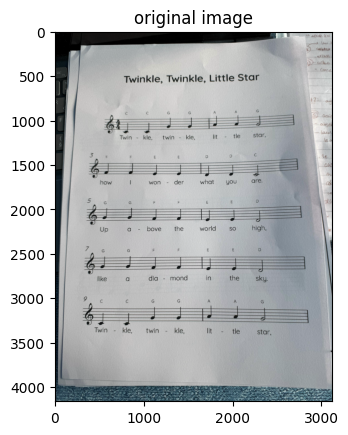

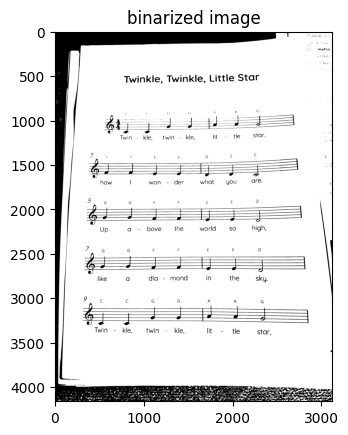

In [415]:
# Read the image
img = cv2.imread("./testcases/1.jpg")
# img = cv2.imread("./images/image2.png")
show_images([img],["original image"])

#remove noise using ski and opencv filters
remove_noise = cv2.bilateralFilter(img, 3, 75, 75)

# Convert to grayscale
gray = cv2.cvtColor(remove_noise, cv2.COLOR_BGR2GRAY)

#dynamic_binarization to apply any of otsu or adaptive
binarized_image=dynamic_binarization(gray)
show_images([binarized_image],["binarized image"])

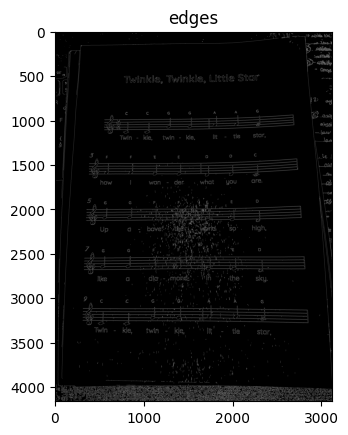

mode result 90.00000250447816


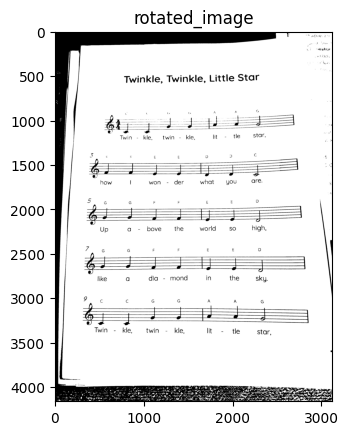

In [416]:
edges = cv2.Canny(gray, 50, 150)
show_images([edges],["edges"])


#detect lines using Hough Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180.0, 250, np.array([]))# show_images([lines],["lines"])


# Rotate the image based on the detected lines
rotated_image = rotate_image(binarized_image,lines)
show_images([rotated_image],["rotated_image"])

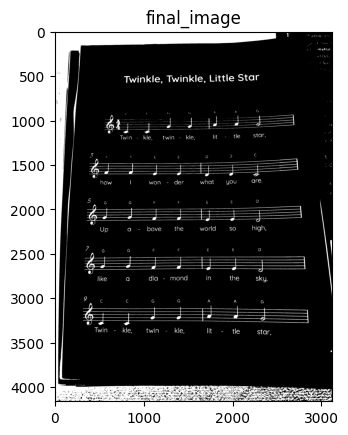

In [417]:
final_image=convert_to_bool_reverse(rotated_image)
show_images([final_image],["final_image"])

In [418]:
# rotated_image_copy=rotated_image.copy()
# #Remove small details
# morphology_input=255-rotated_image
# morphology_input=morphology_input>0
# # closing=binary_erosion(morphology_input,footprint= np.ones((1, 5)))
# dilation=binary_dilation(morphology_input, np.ones((5,1)))
# dilation=remove_small_objects(dilation, 500, connectivity=8)
# # print(dilation)


# # Find contours of big bounding box all notes
# # closing=binary_erosion(dilation,footprint= np.ones((1, 5)))
# dilation=binary_dilation(dilation, np.ones((200,10)))
# show_images([dilation],[ "dilation"])

# contours_input= (dilation * 255).astype('uint8')
# # show_images([contours_input],["contors"])
# # print(contours_input)
# contours, _ = cv2.findContours(contours_input, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Create a copy of the original image to draw the bounding boxes
# output_image = cv2.cvtColor(rotated_image, cv2.COLOR_GRAY2BGR)


# max_area = 0
# max_bbox = None  # Will store the coordinates of the maximum bounding box
# # Loop over the contours to get the bounding rectangles
# for contour in contours:

#     # Get the bounding rectangle (x, y, width, height)
#     x, y, w, h = cv2.boundingRect(contour)
#     cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
#     # Calculate the area of the bounding rectangle
#     area = w * h
#     # Check if this is the largest bounding box so far
#     if area > max_area:
#         max_area = area
#         max_bbox = (x, y, w, h)
# if max_bbox is not None:
#     x, y, w, h = max_bbox
#     print("maxx")
#     cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# # Display the result with bounding boxes
# # cv2.imshow('Bounding Rectangles', output_image)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# show_images([output_image],["output_image"])


# # x, y, w, h = max_bbox
# # cropped_image = rotated_image_copy[y:y+h, x:x+w]
# # show_images([cropped_image],["cropped_image1"])

# # cropped_image=255-cropped_image
# # cropped_image=cropped_image>0
# final_image=remove_small_objects(output_image, 700, connectivity=8)

# show_images([final_image],["final_image"])




STAVE EXTRACTION
1. Apply run length encoding to get staff height and staff space
2. dilate with staff space
3. apply countours
4. extract these countours
5. loop on staves and remove staff lines around notes
6. dilate the rest of notes
7. apply contours on each stave to get single notes 
8. Further process each single note and remove small objects

max_dim 4160


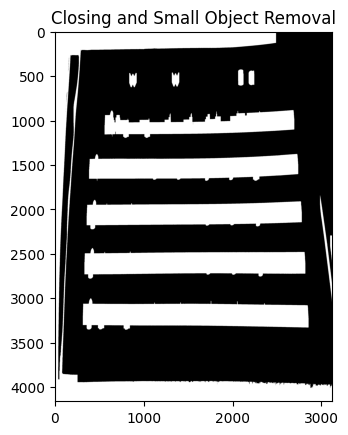

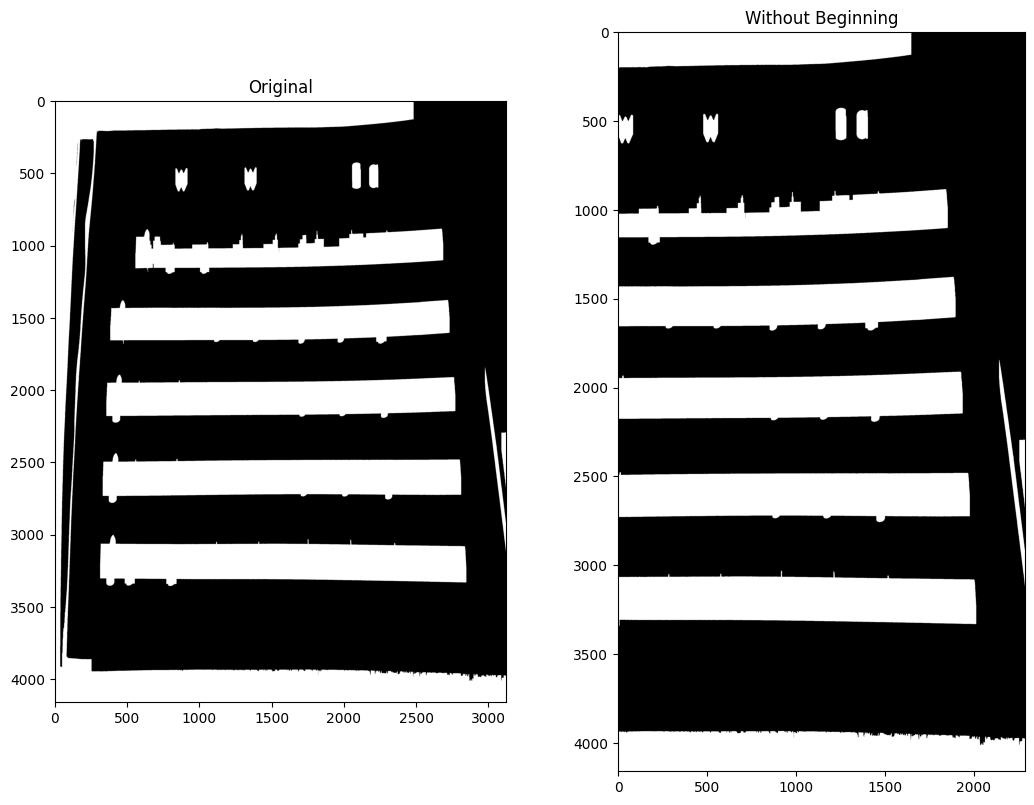

Stave Length:  2014 Stave Height:  311


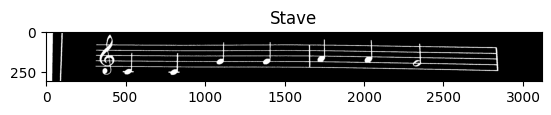

Stave Length:  1978 Stave Height:  281


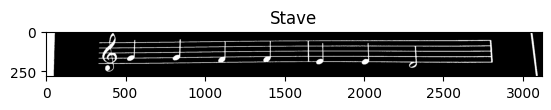

Stave Length:  1938 Stave Height:  282


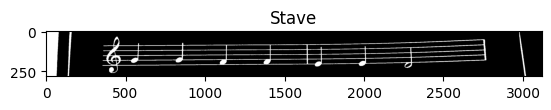

Stave Length:  1898 Stave Height:  302


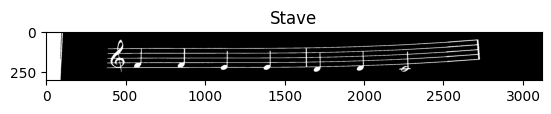

Stave Length:  1854 Stave Height:  312


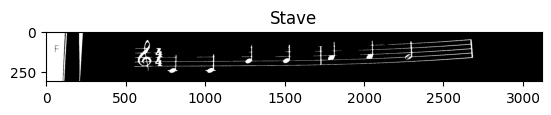

In [419]:

#staves using contoursxx
staves=getBoundedBoxes(final_image)
# for i , stave in enumerate(staves):
#     # staves[i] = remove_small_objects(stave, 2000, connectivity=8)

#     print(stave.shape)
#     show_images([stave],["stave"])


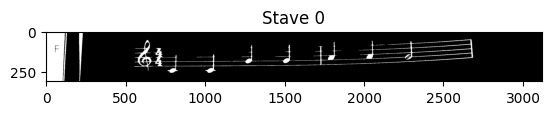

stave shape (312, 3120)
staff_height 2
staff_space 26


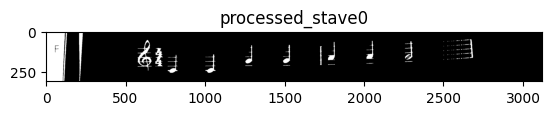

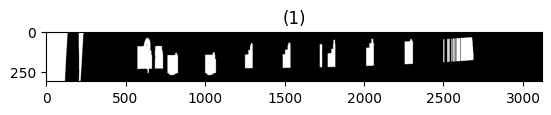

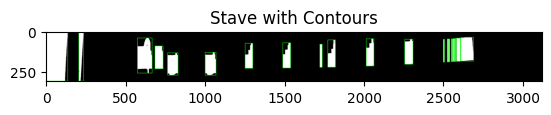

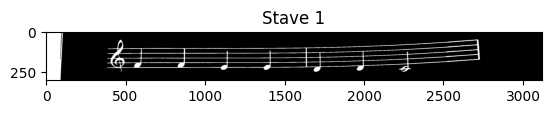

stave shape (302, 3120)
staff_height 4
staff_space 26


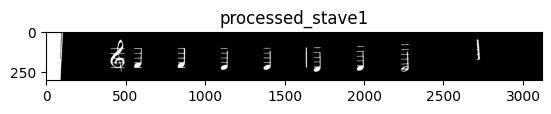

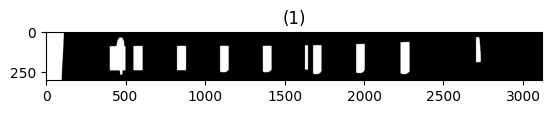

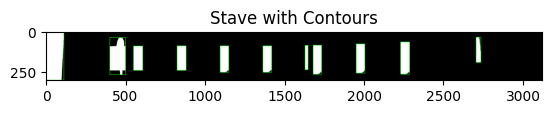

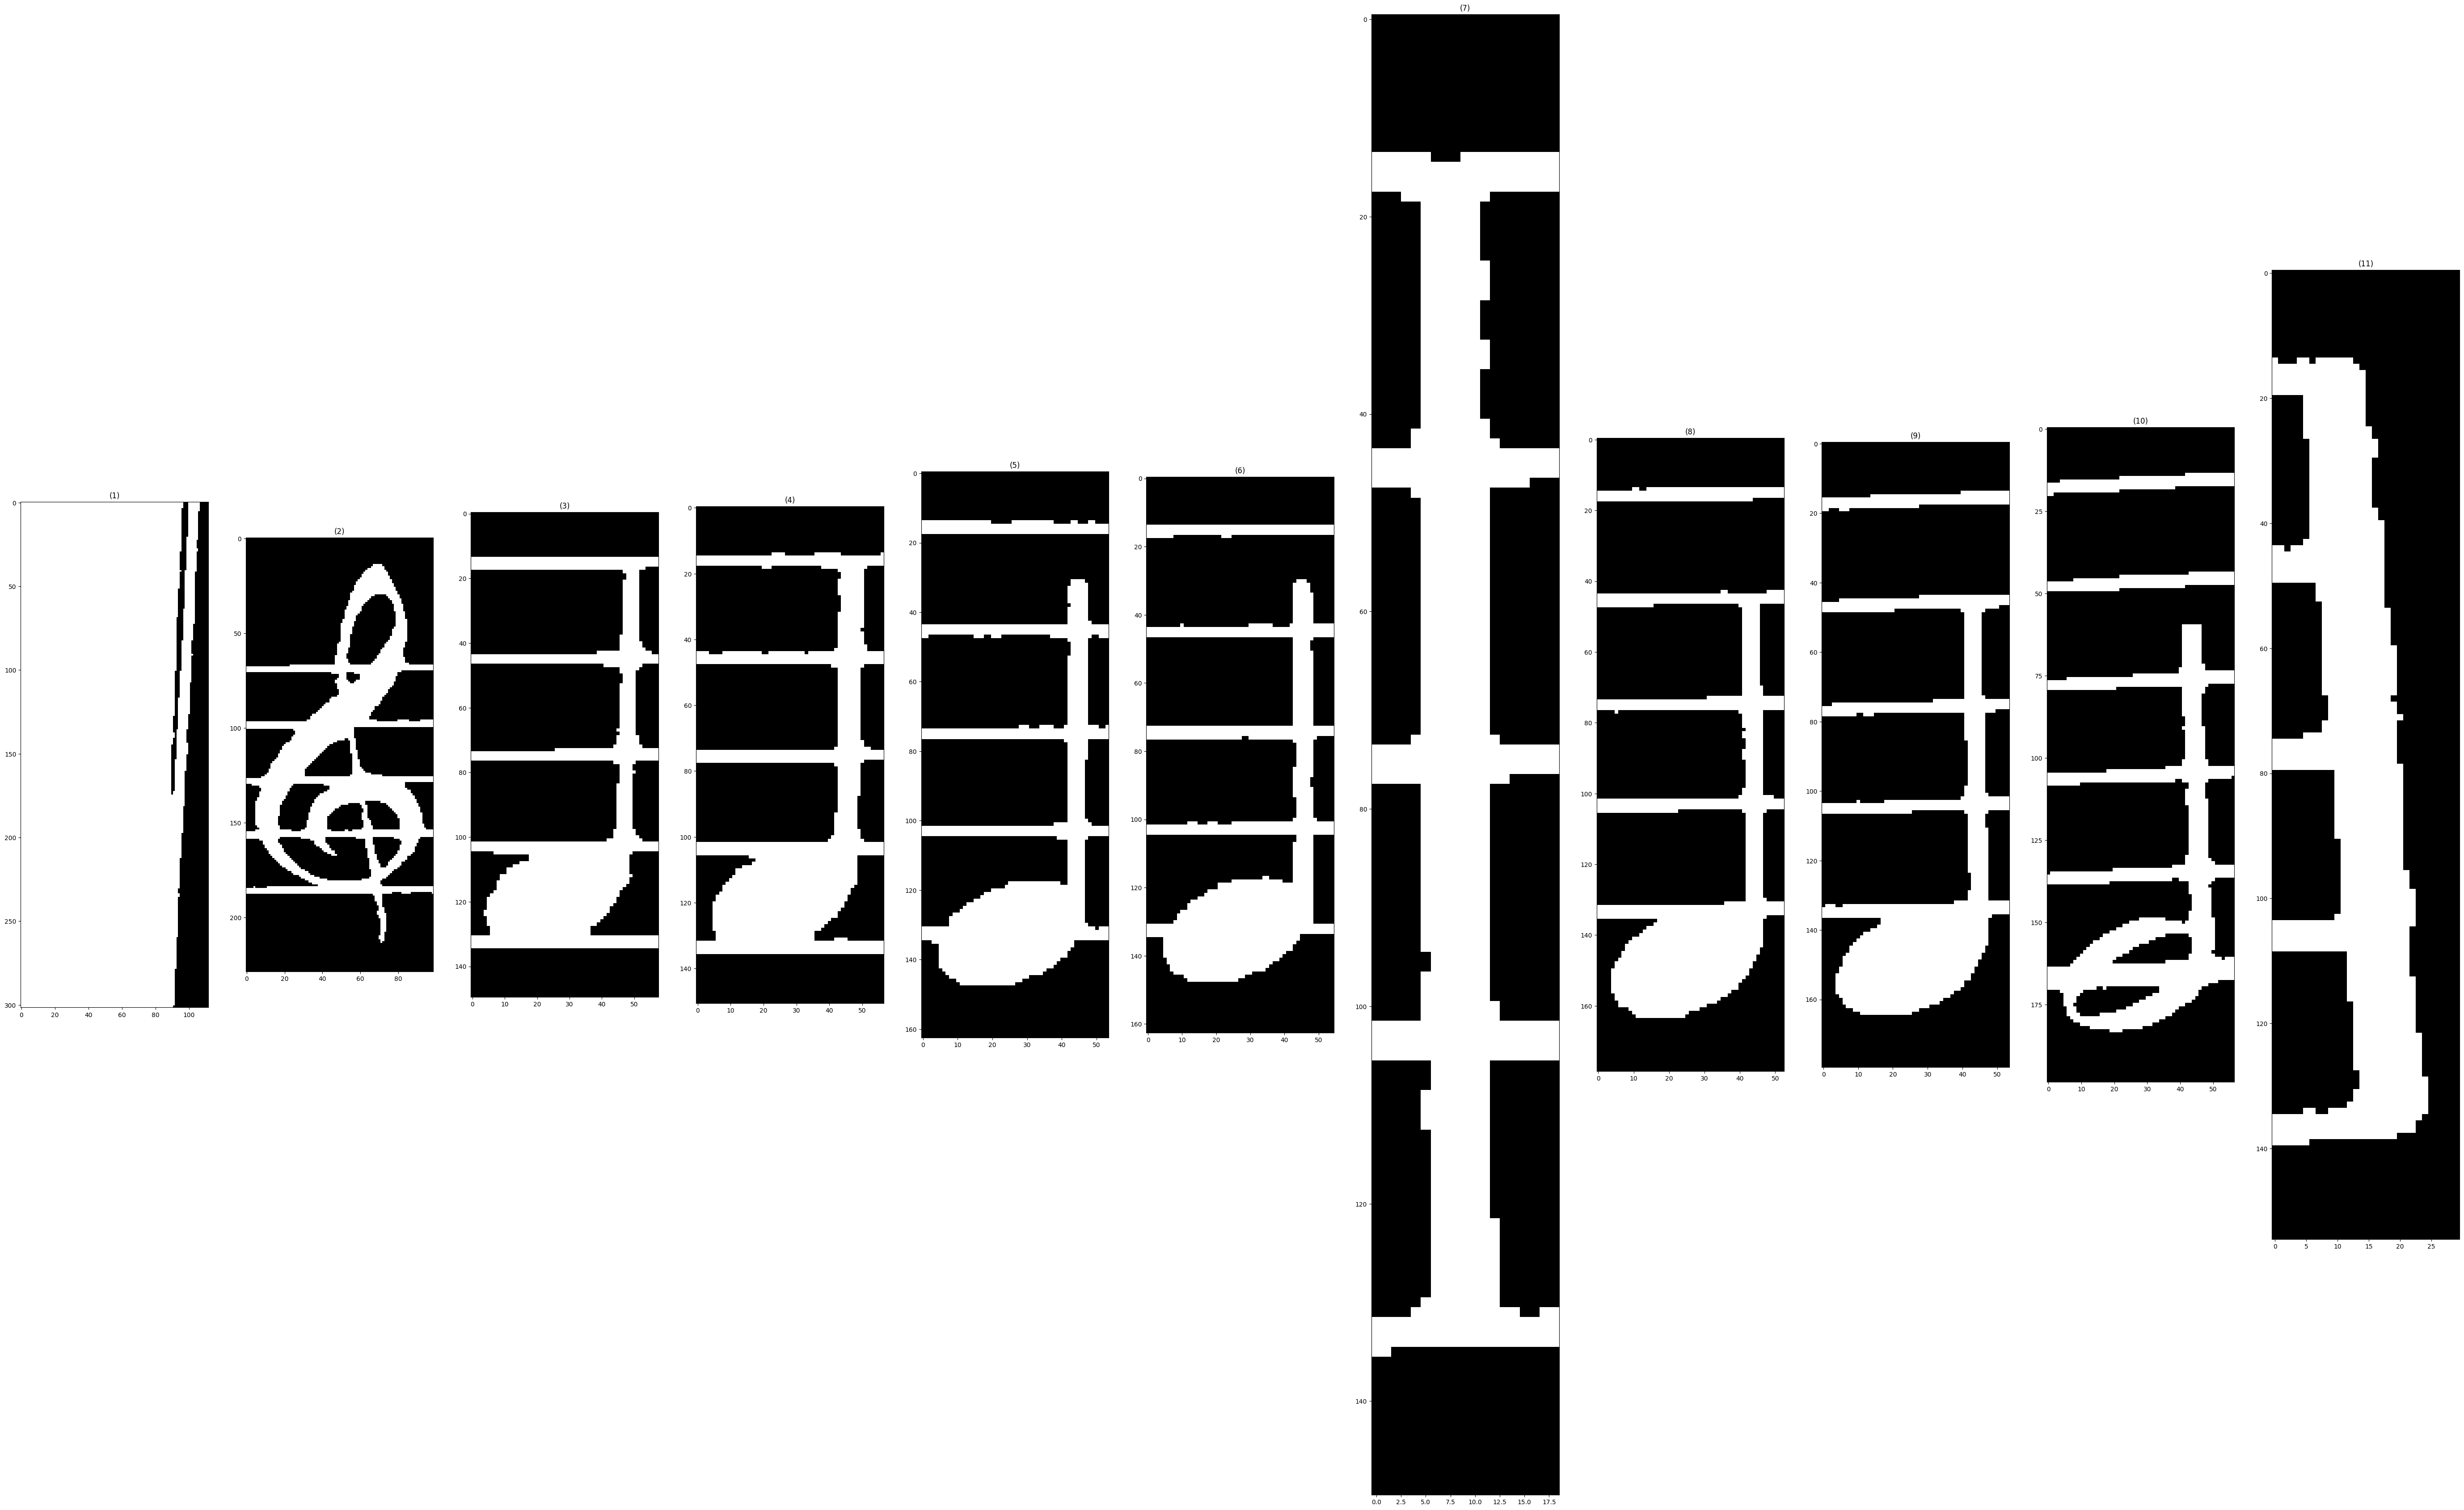

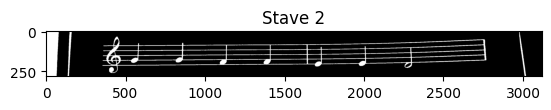

stave shape (282, 3120)
staff_height 4
staff_space 27


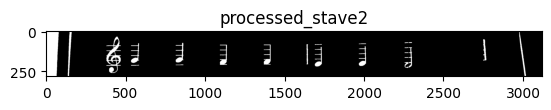

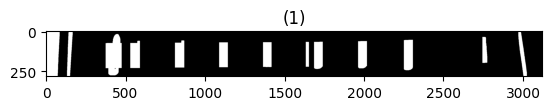

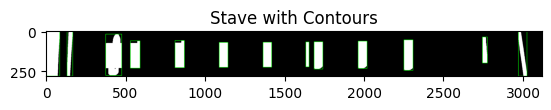

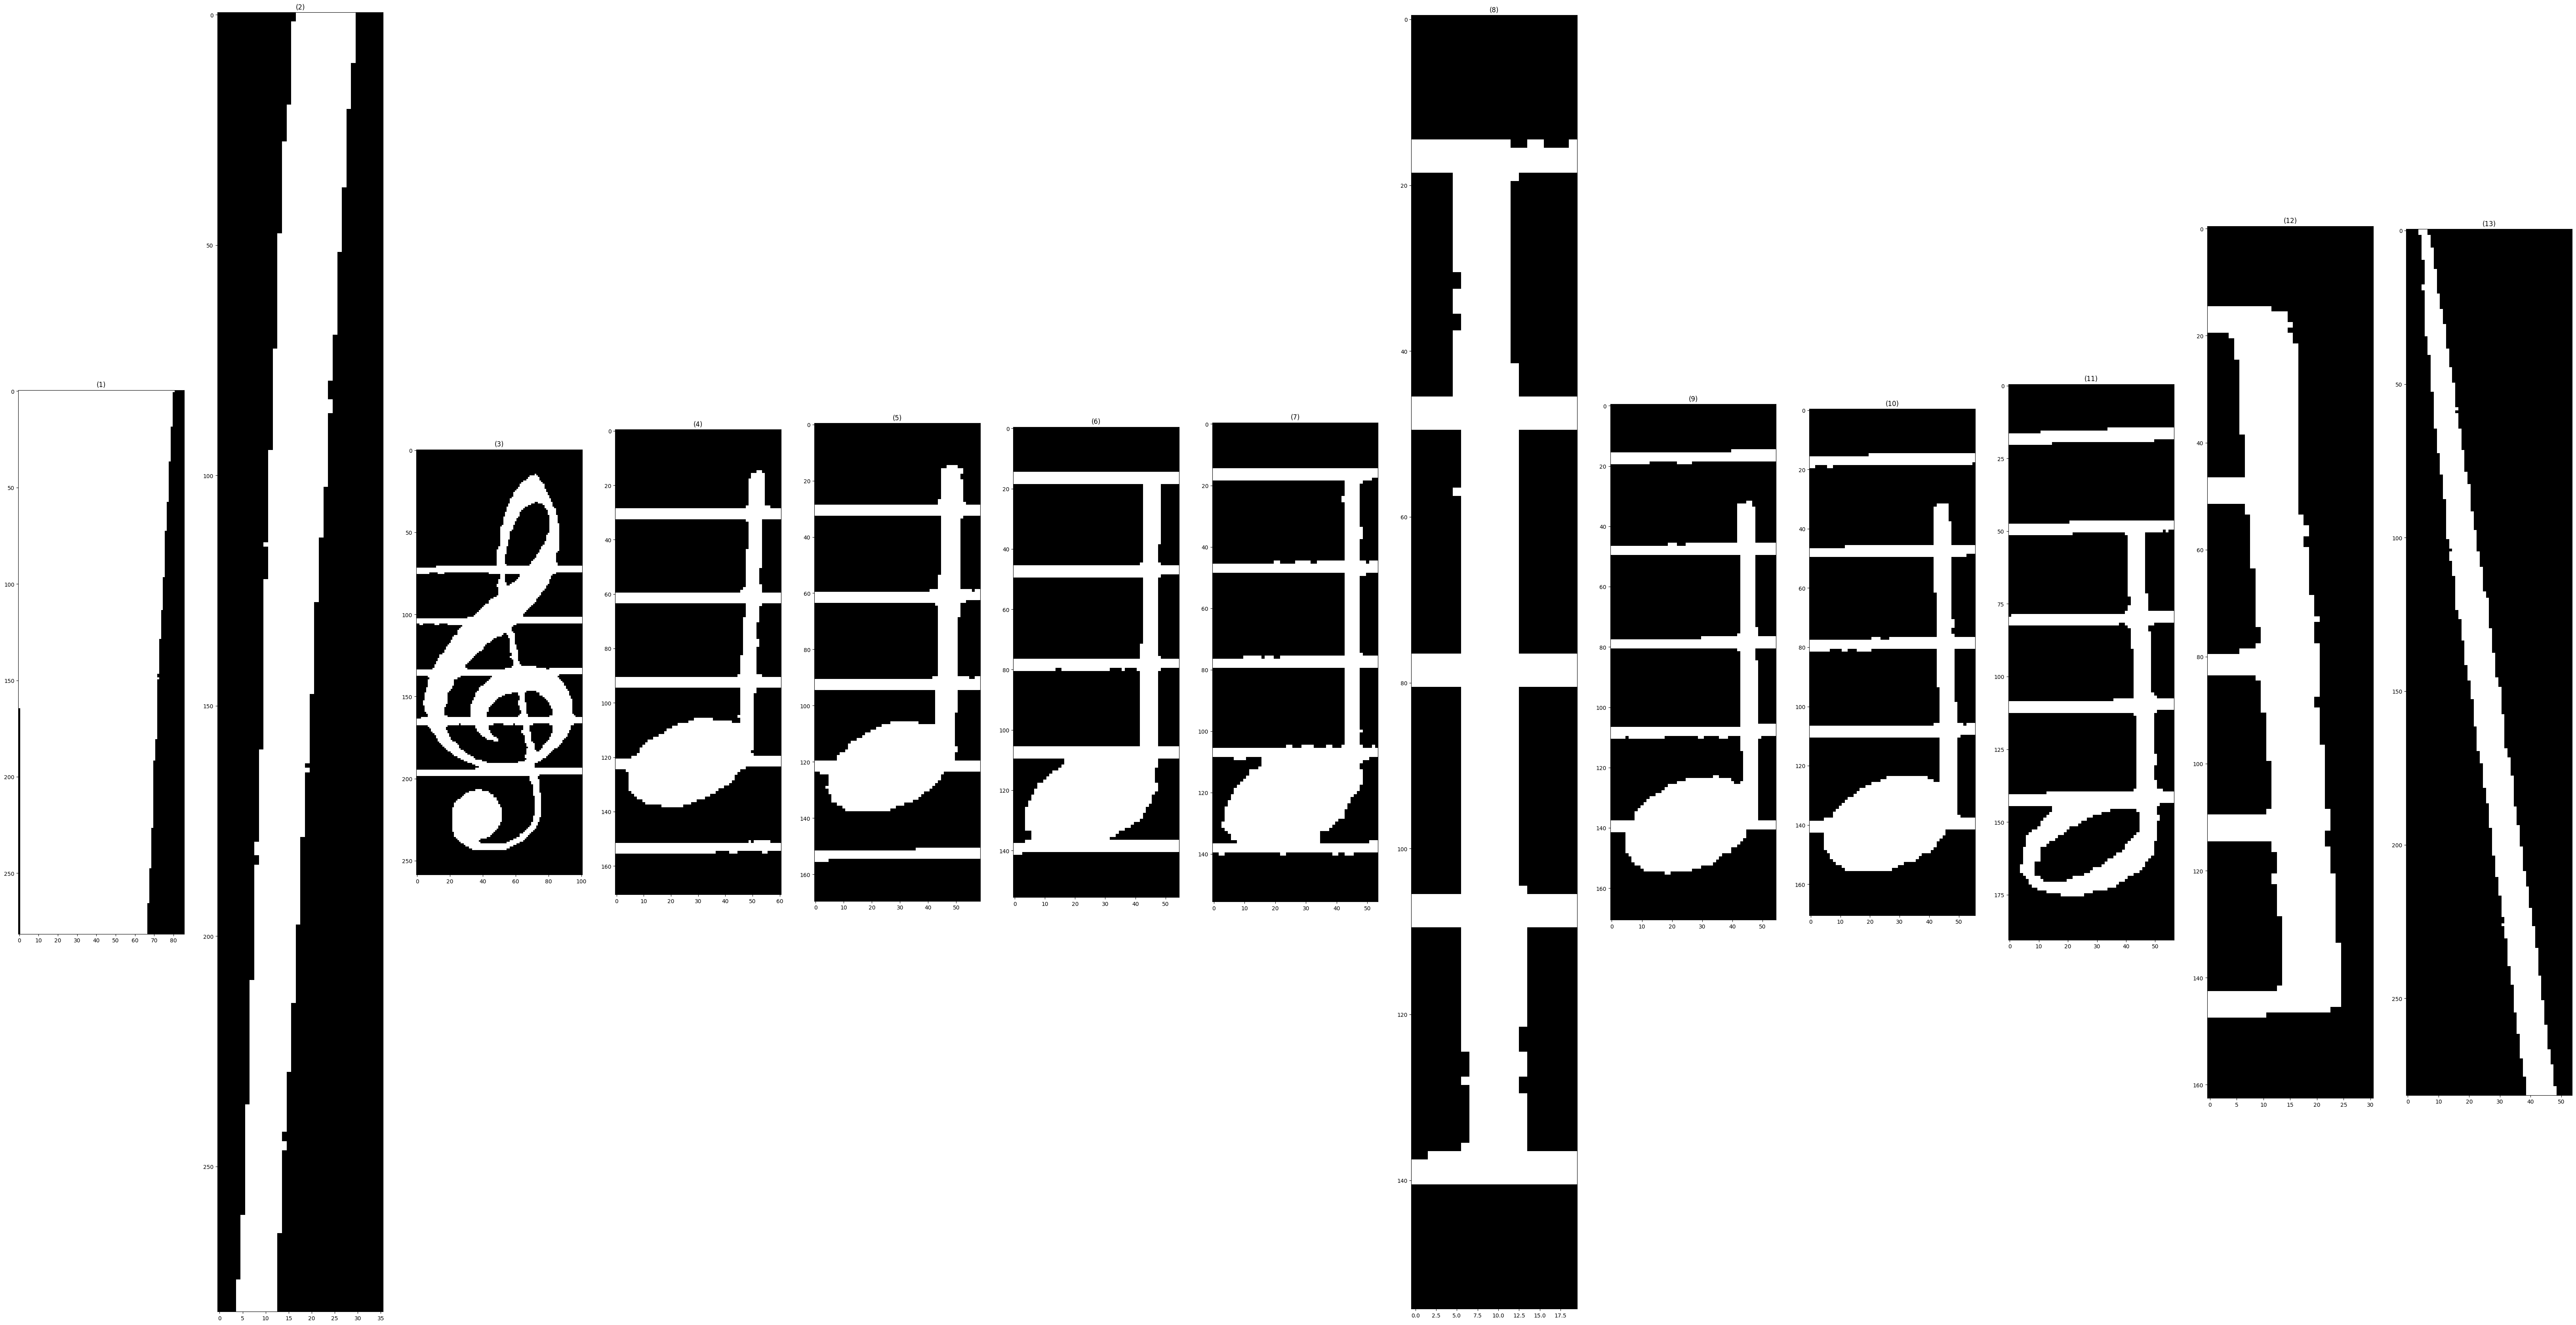

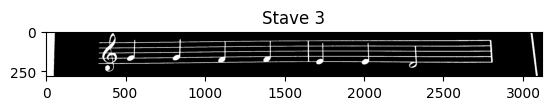

stave shape (281, 3120)
staff_height 4
staff_space 29


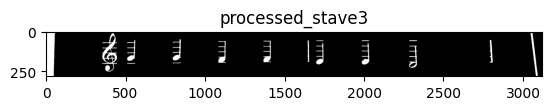

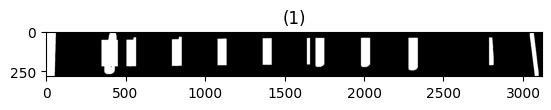

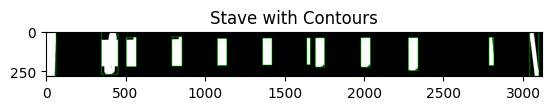

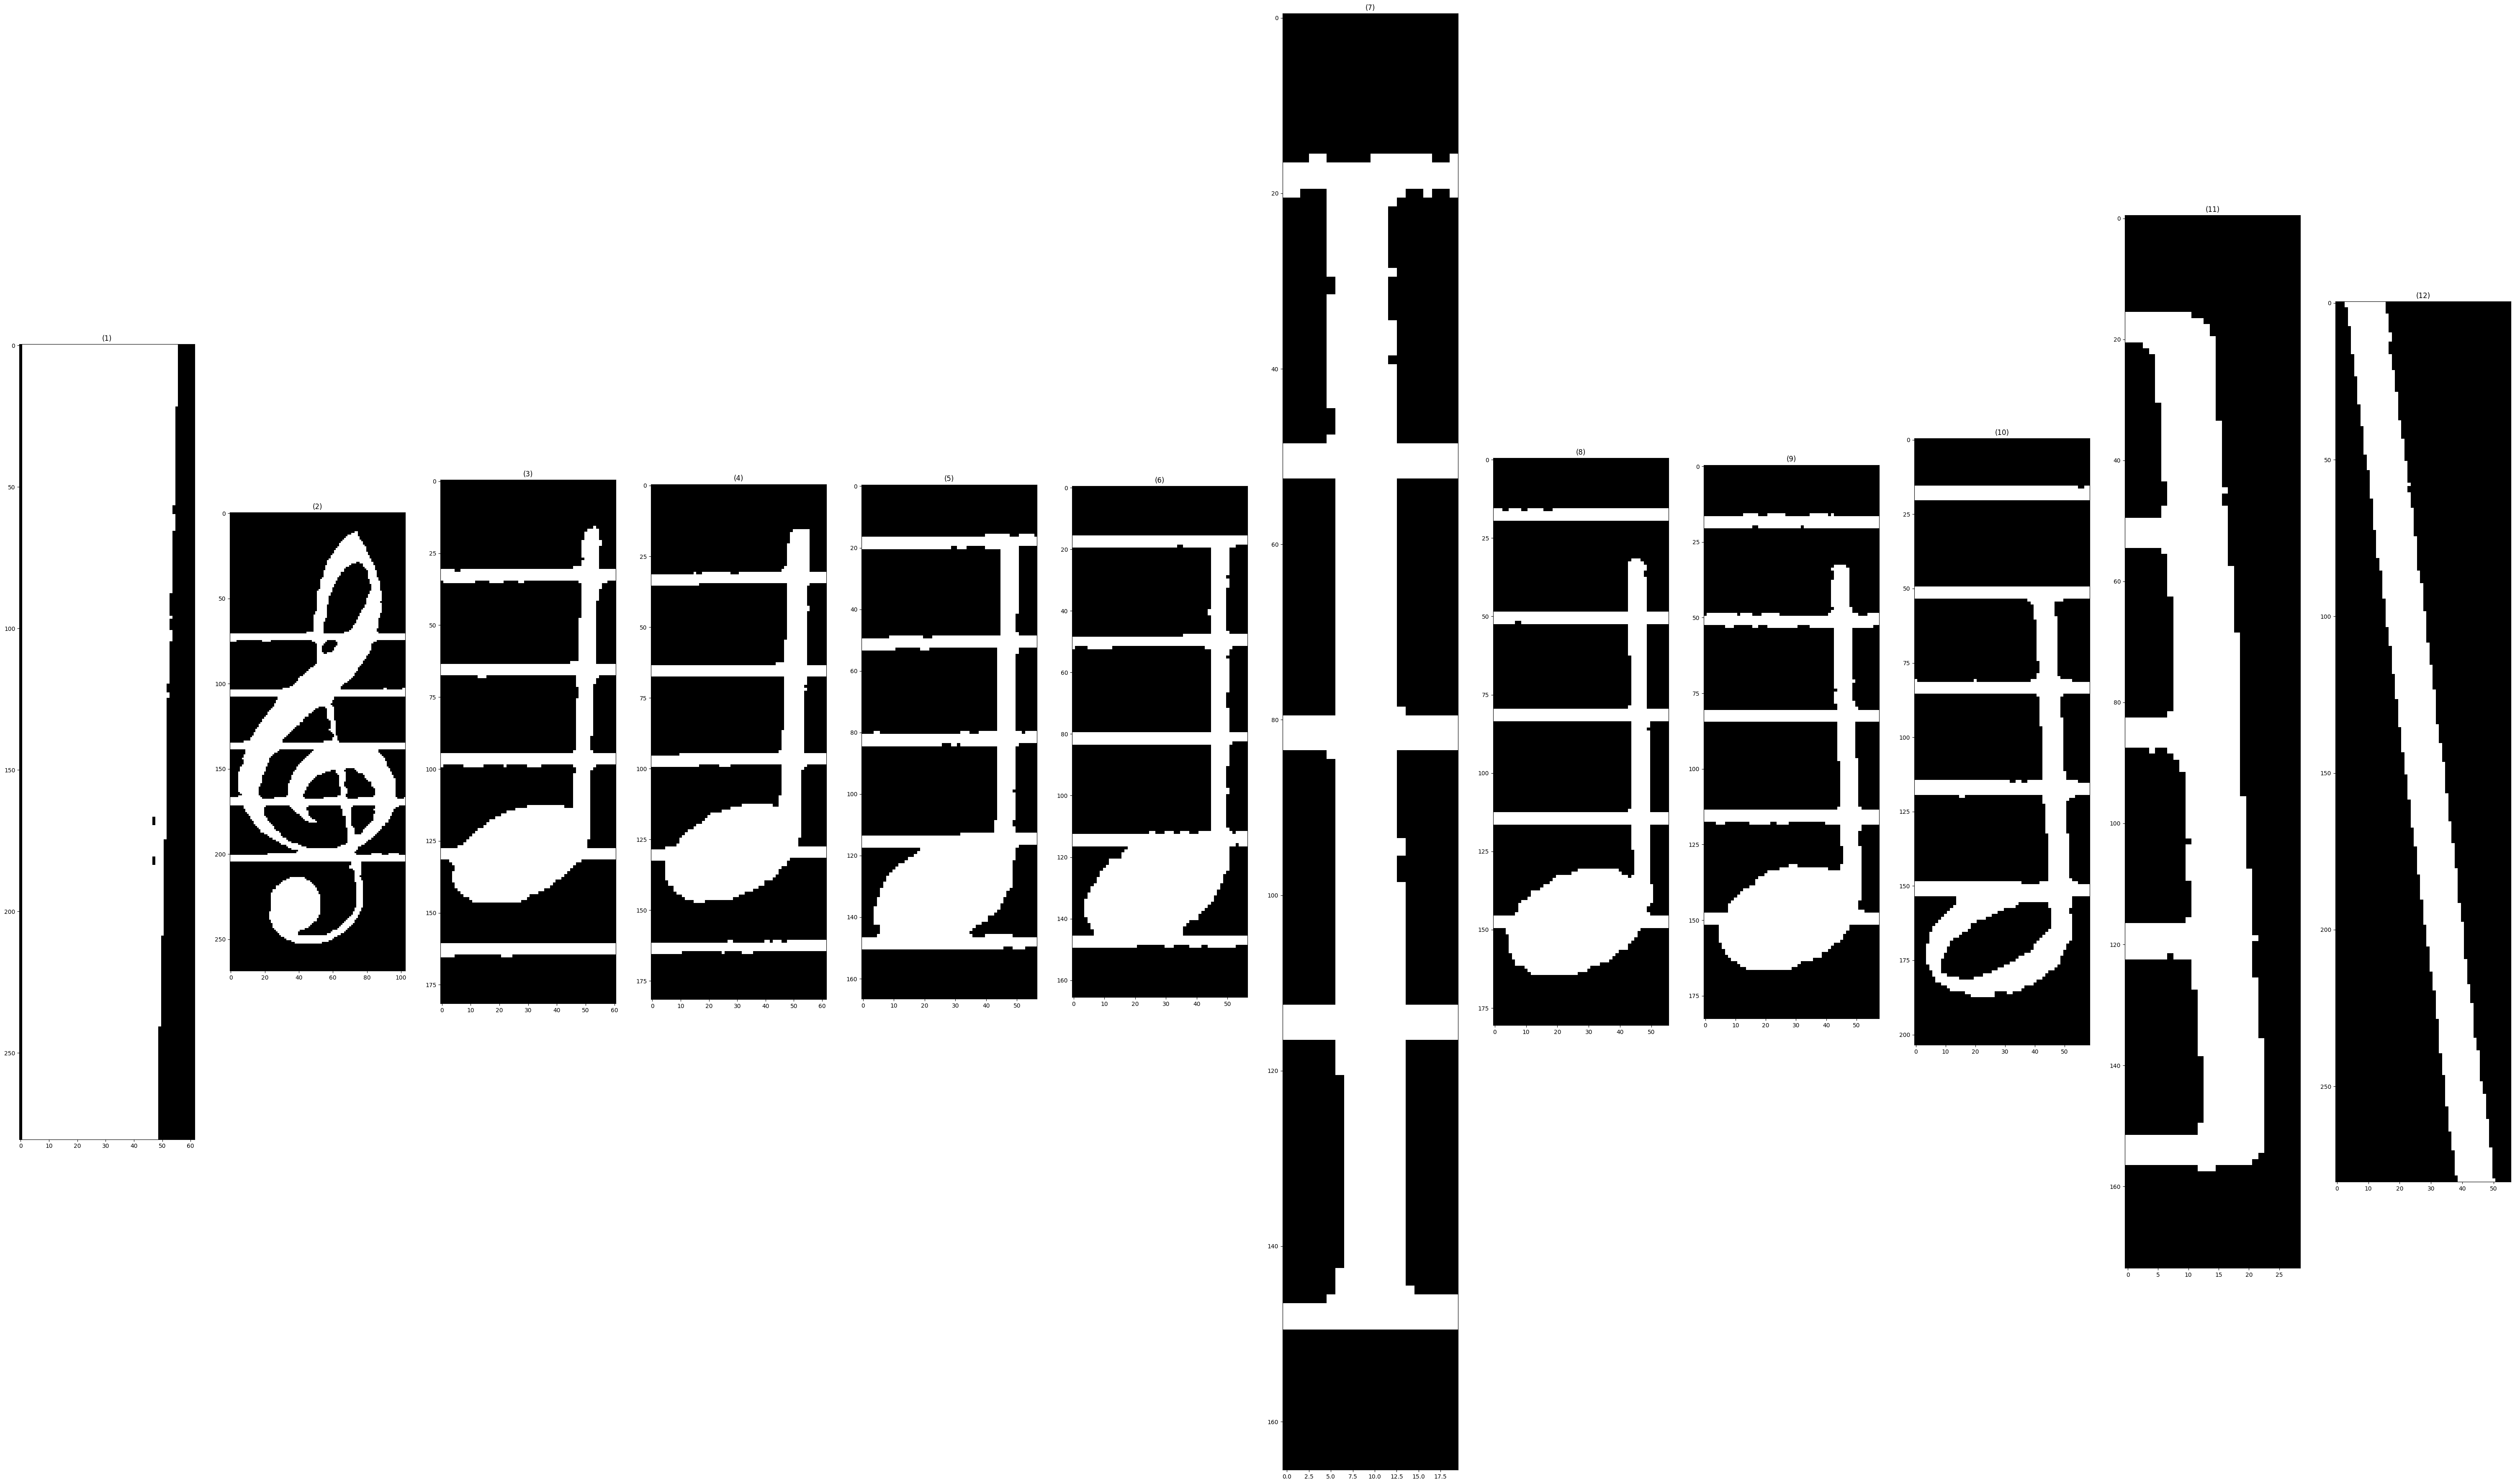

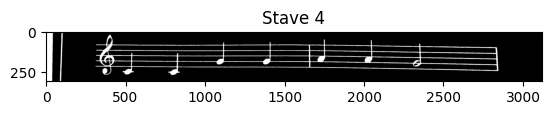

stave shape (311, 3120)
staff_height 4
staff_space 31


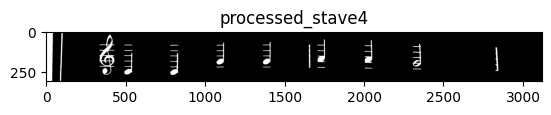

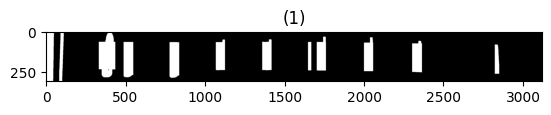

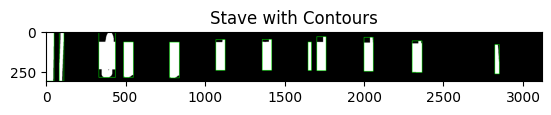

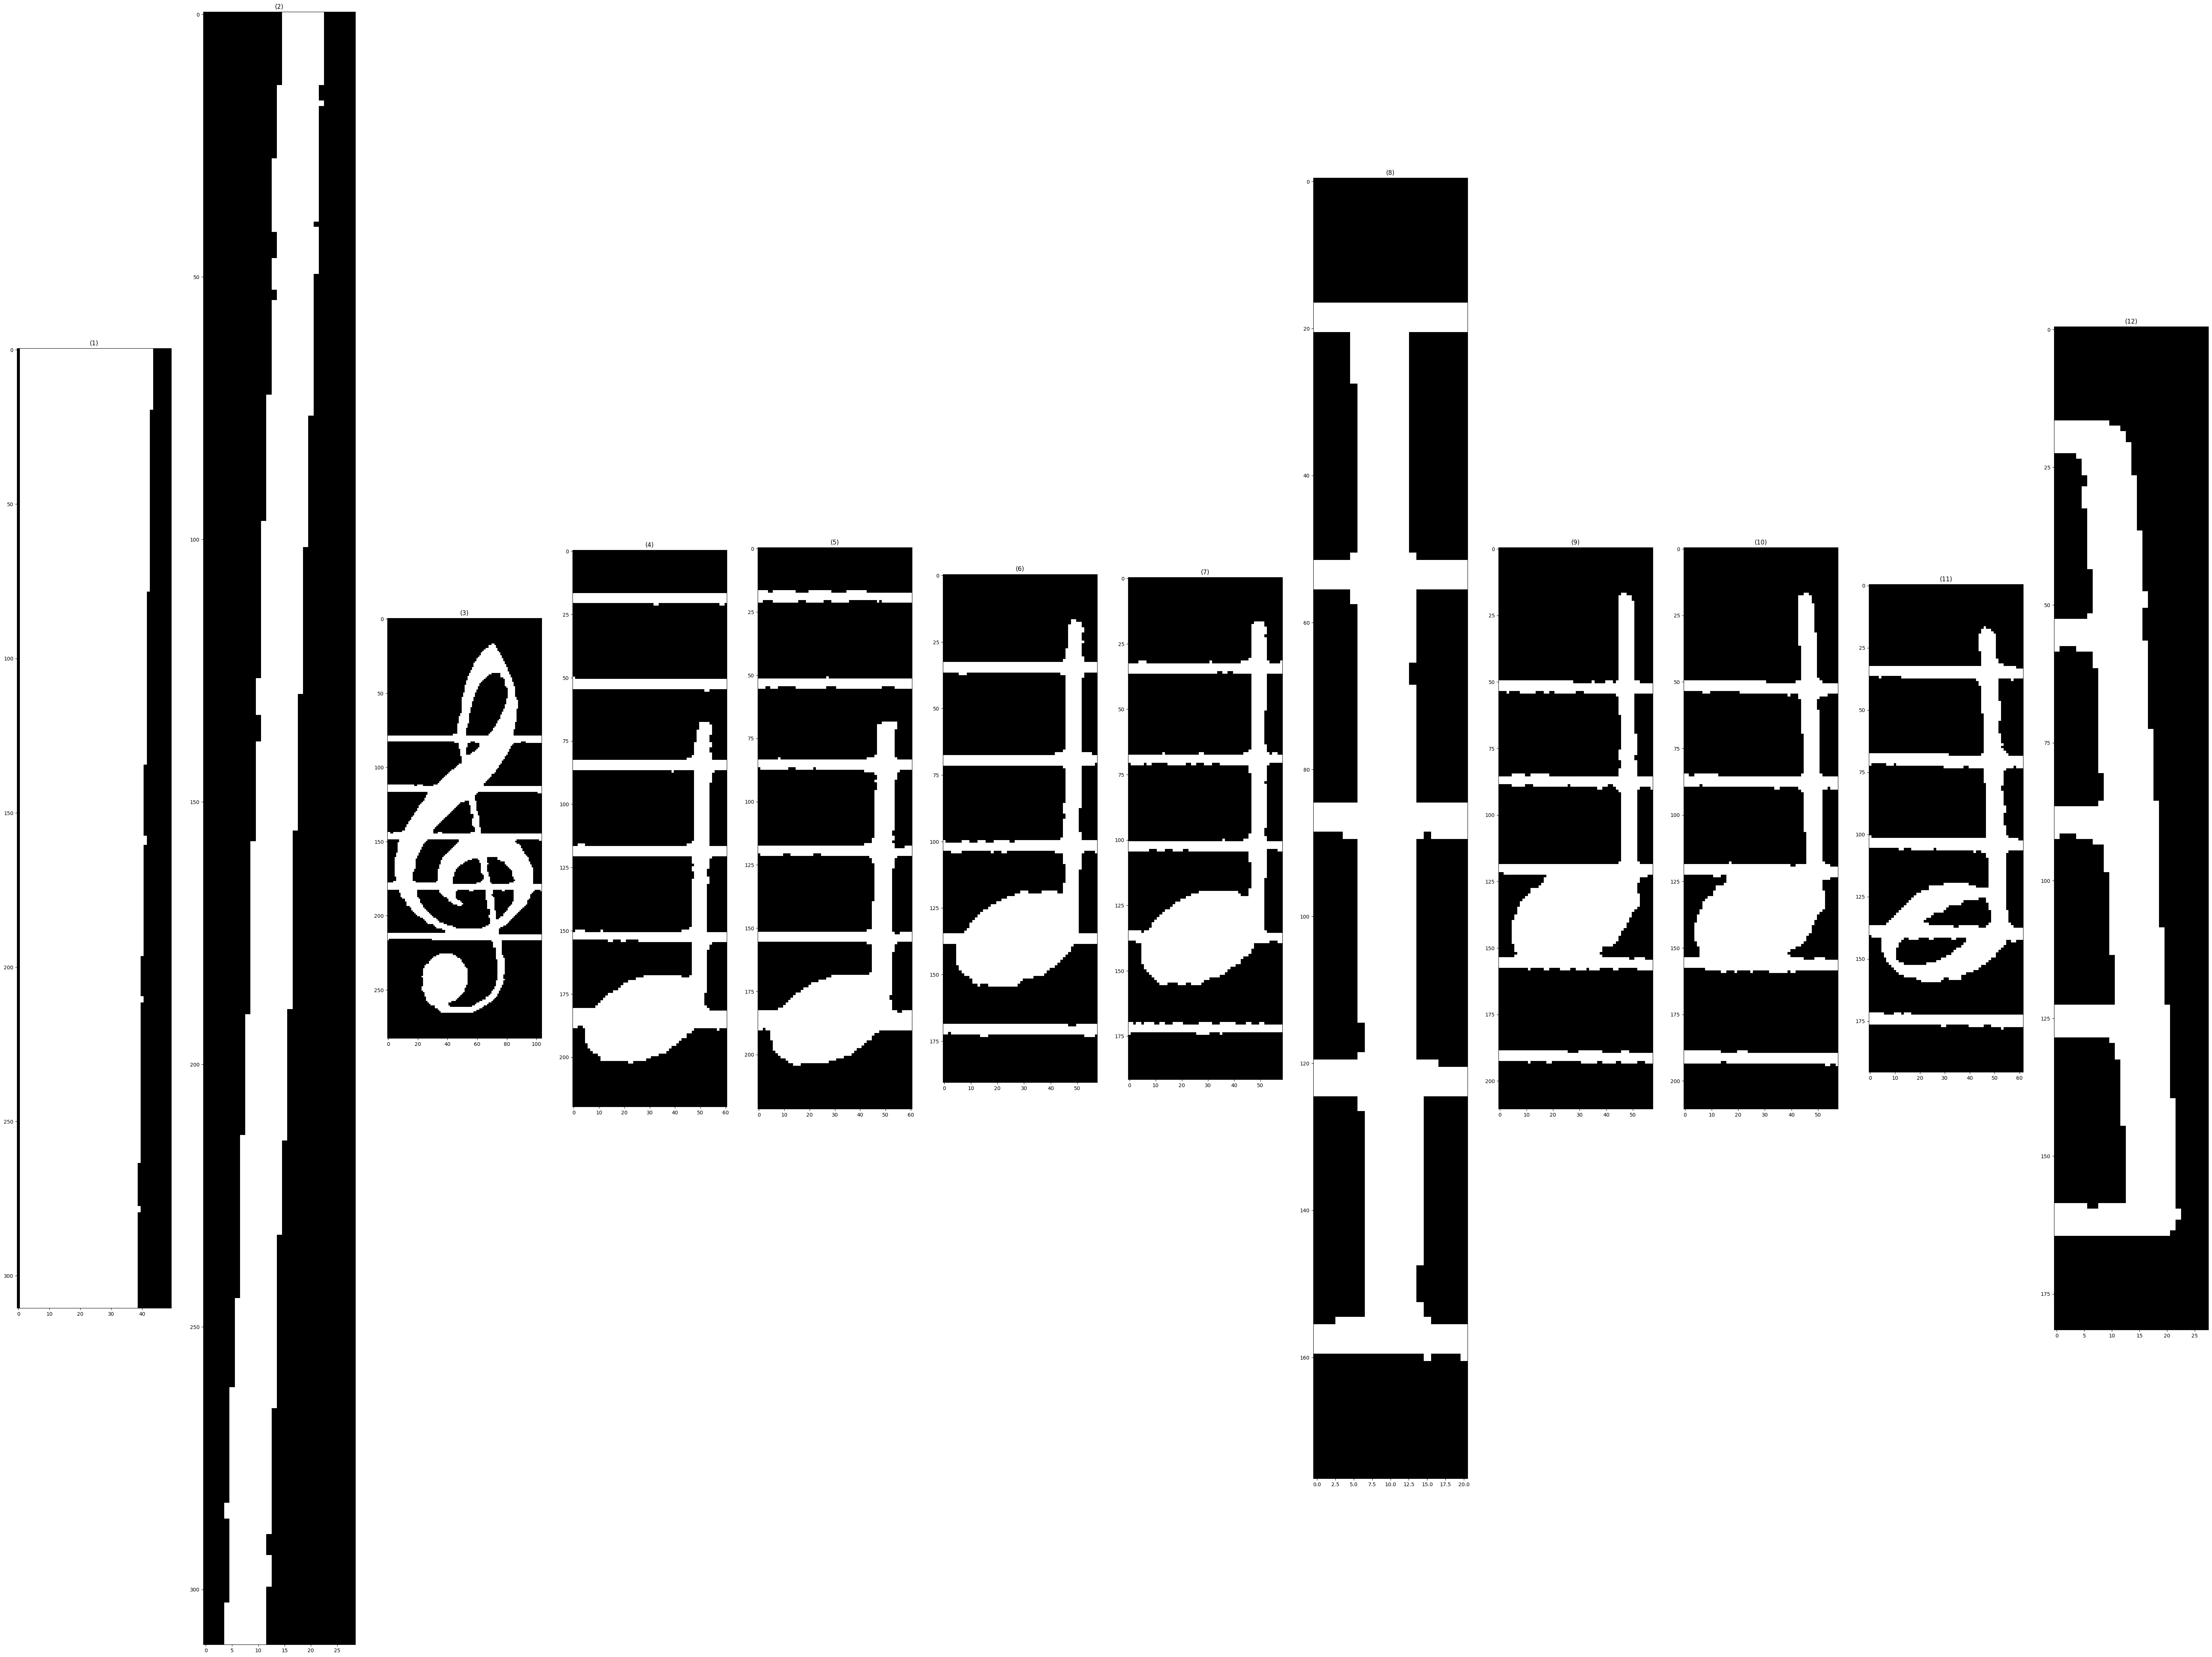

In [448]:
all_notes=[]
for i, stave in enumerate(staves):
    show_images([stave], [f"Stave {i}"])
    print("stave shape",stave.shape)
    
    #Get staff_height, staff_sapce
    staff_height,staff_space = verticalRunLength(stave)
    print("staff_height",staff_height)
    print("staff_space",staff_space)
    
    #remove staff lines using runlength encoding
    processed_stave = remove_staff_lines_columnwise(stave, staff_height)
    show_images([processed_stave],[f"processed_stave{i}"])
    
    #Use dilation again to sengment notes from staves after staff lines removal
    dilated_stave = dilate_vertically_with_staff_space(processed_stave, staff_height * 3, staff_space + staff_height)
    show_images([dilated_stave])
    
    #Get notes from the staves using contours
    notes = segment_staves(dilated_stave, stave,staff_space)
    all_notes.append(notes)
    show_images(notes)


# for i, stave in enumerate(staves):
#     show_images([stave], [f"Stave {i}"])
    
#     #Get staff_height, staff_sapce
#     staff_height,staff_space = verticalRunLength(stave)
#     print("staff_height",staff_height)
#     print("staff_space",staff_space)

    

# #Remove Staff line using runlength encoding
# processed_staves = remove_staff_lines_columnwise(staves, staff_height)


# # Show the processed staves
# for i, stave in enumerate(processed_staves):
#     show_images([stave], [f"Processed Stave {i}"])
    
# #Use dilation again to sengment notes from staves after staff lines removal
# dilated_staves=[]
# for i in range(len(processed_staves)):
#     dilated_stave = dilate_vertically_with_staff_space(processed_staves[i], staff_height * 3, staff_space + staff_height)
#     dilated_staves.append(dilated_stave)

# show_images(dilated_staves)

# #Get notes from the staves using contours
# notes=[]
# for i in range(len(dilated_staves)):
#     notes.append(segment_staves(dilated_staves[i], processed_staves[i],staff_space))    

# for i, note in enumerate(notes):
#     show_images(note)


-----------------
note[0][0] shape: (312, 136)
note[0][1] shape: (219, 92)
note[0][2] shape: (139, 66)
note[0][3] shape: (142, 68)
note[0][4] shape: (156, 48)
note[0][5] shape: (157, 49)
note[0][6] shape: (144, 15)
note[0][7] shape: (170, 48)
note[0][8] shape: (156, 52)
note[0][9] shape: (143, 7)
note[0][10] shape: (143, 6)
note[0][11] shape: (143, 7)
note[0][12] shape: (145, 25)


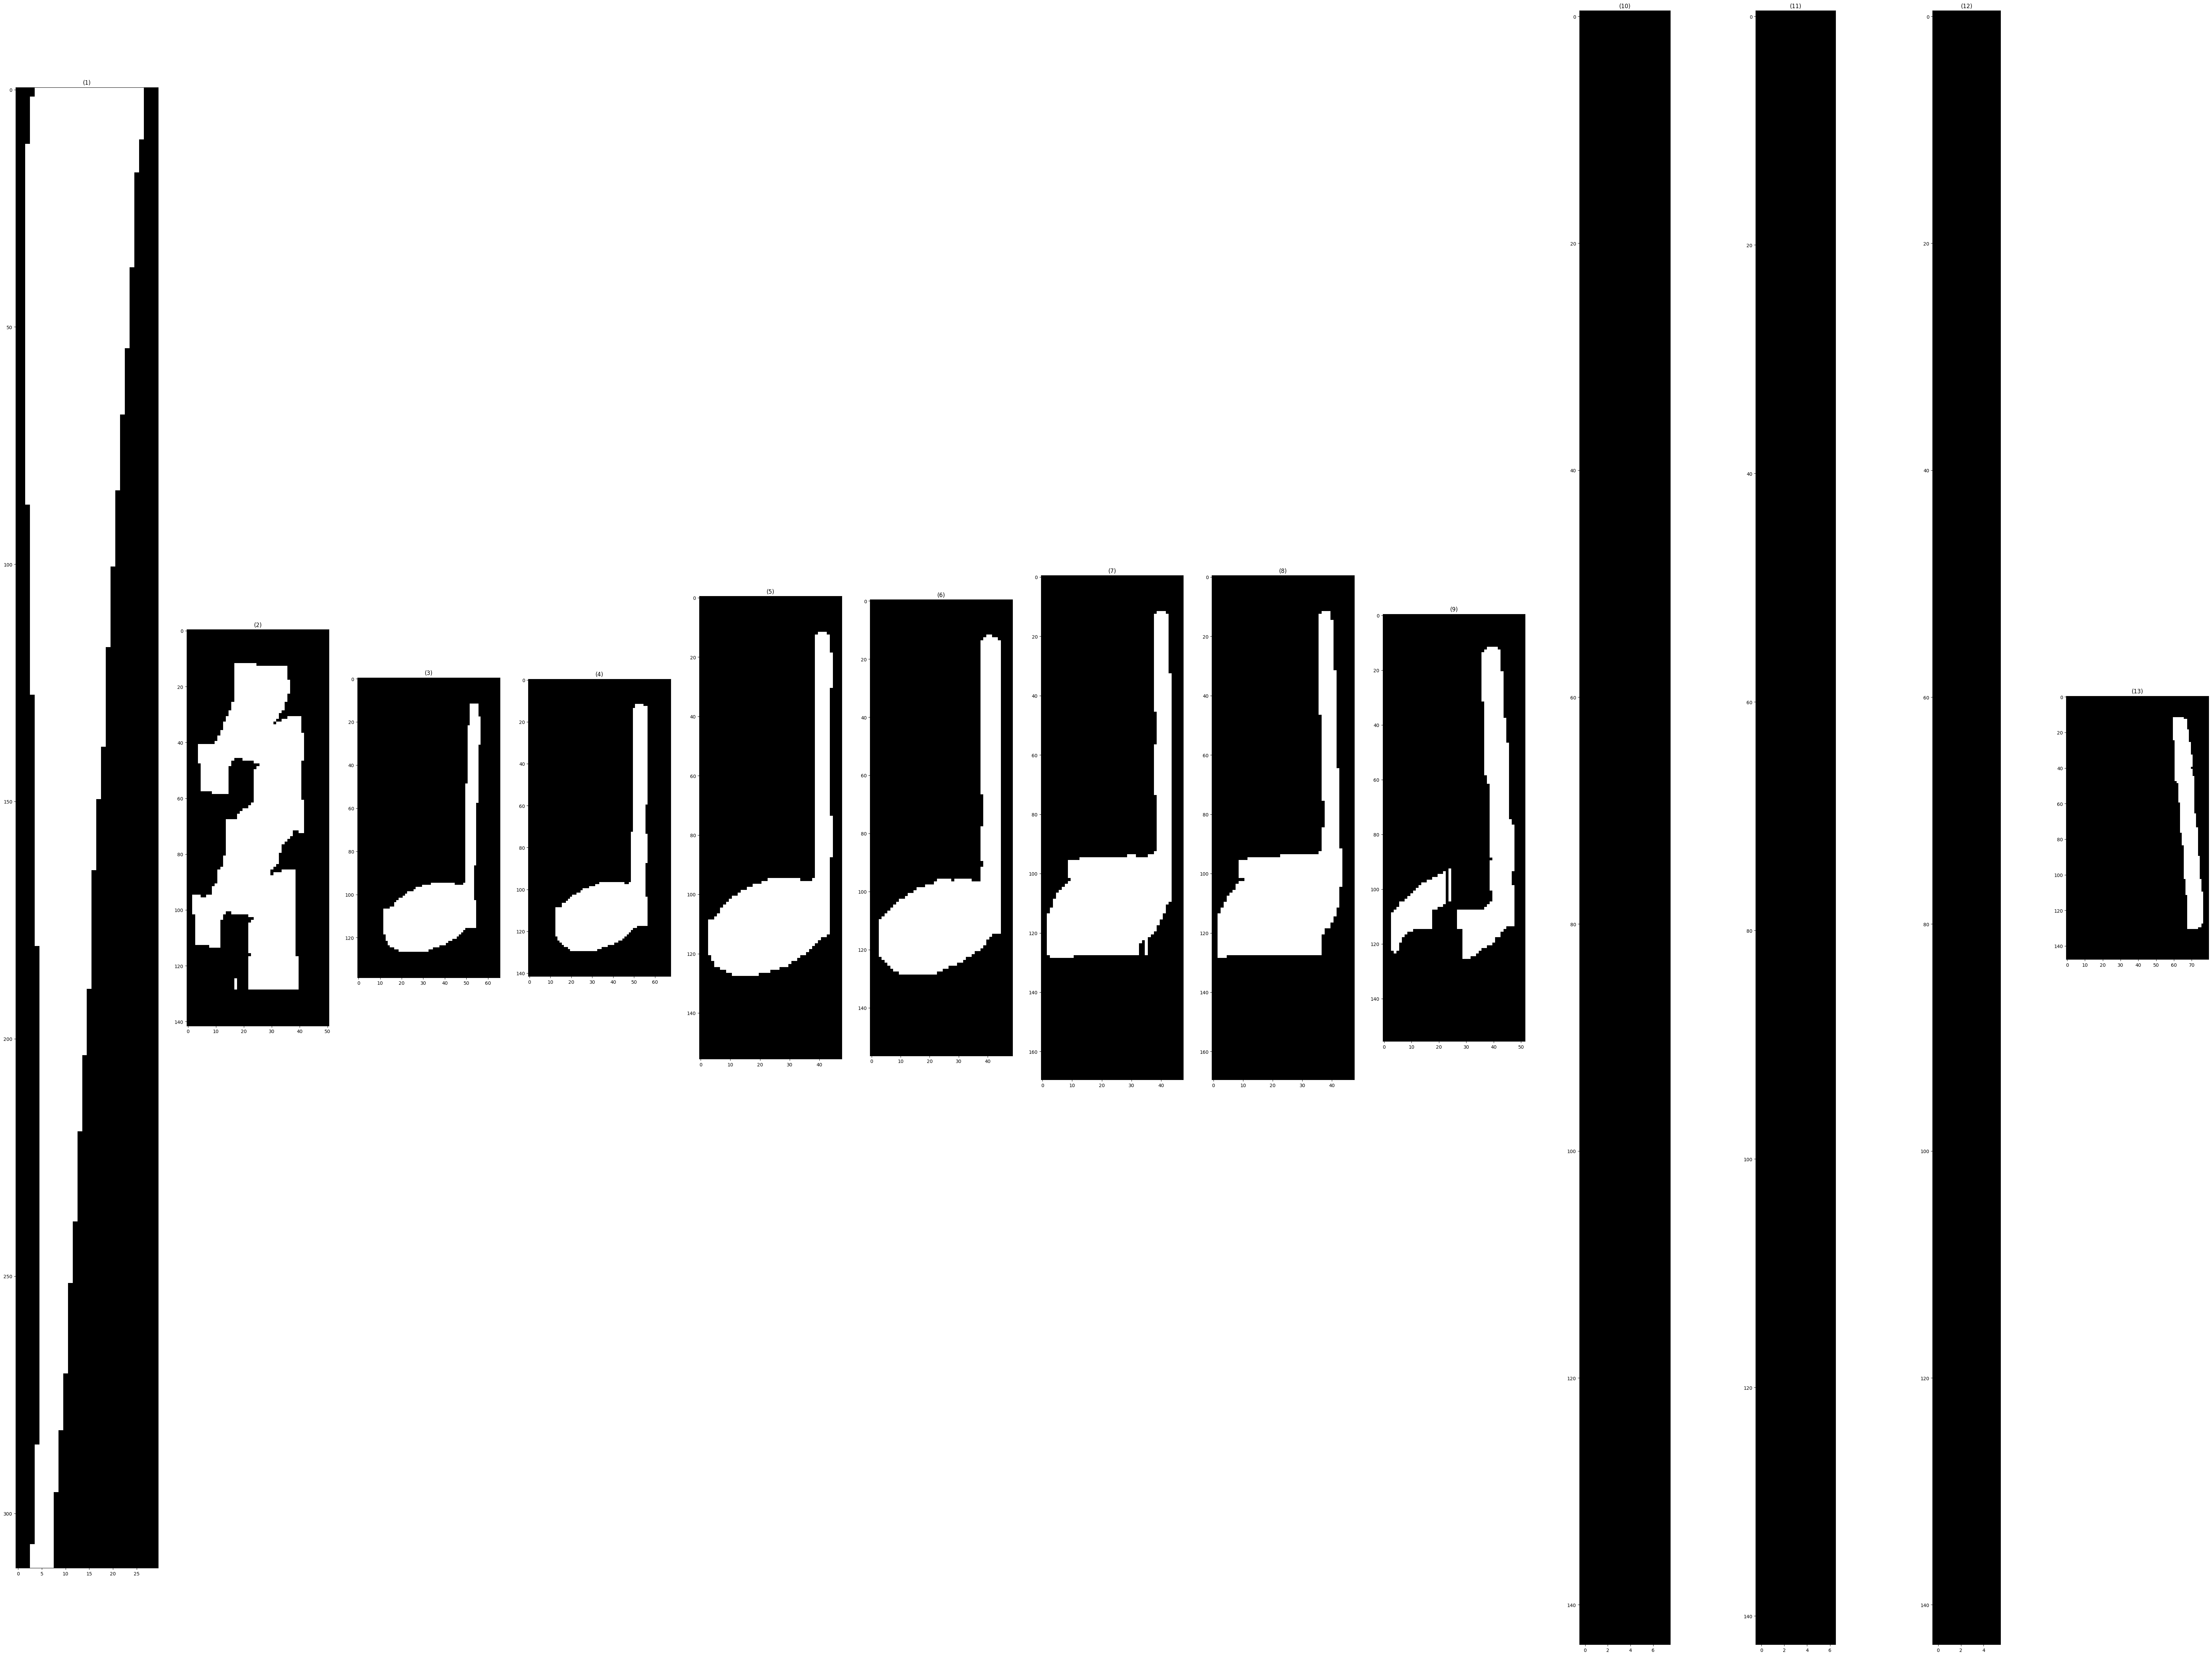

note[1][0] shape: (302, 112)
note[1][1] shape: (150, 58)
note[1][2] shape: (151, 57)
note[1][3] shape: (163, 54)
note[1][4] shape: (163, 55)
note[1][5] shape: (150, 19)
note[1][6] shape: (180, 54)
note[1][7] shape: (199, 57)
note[1][8] shape: (155, 30)


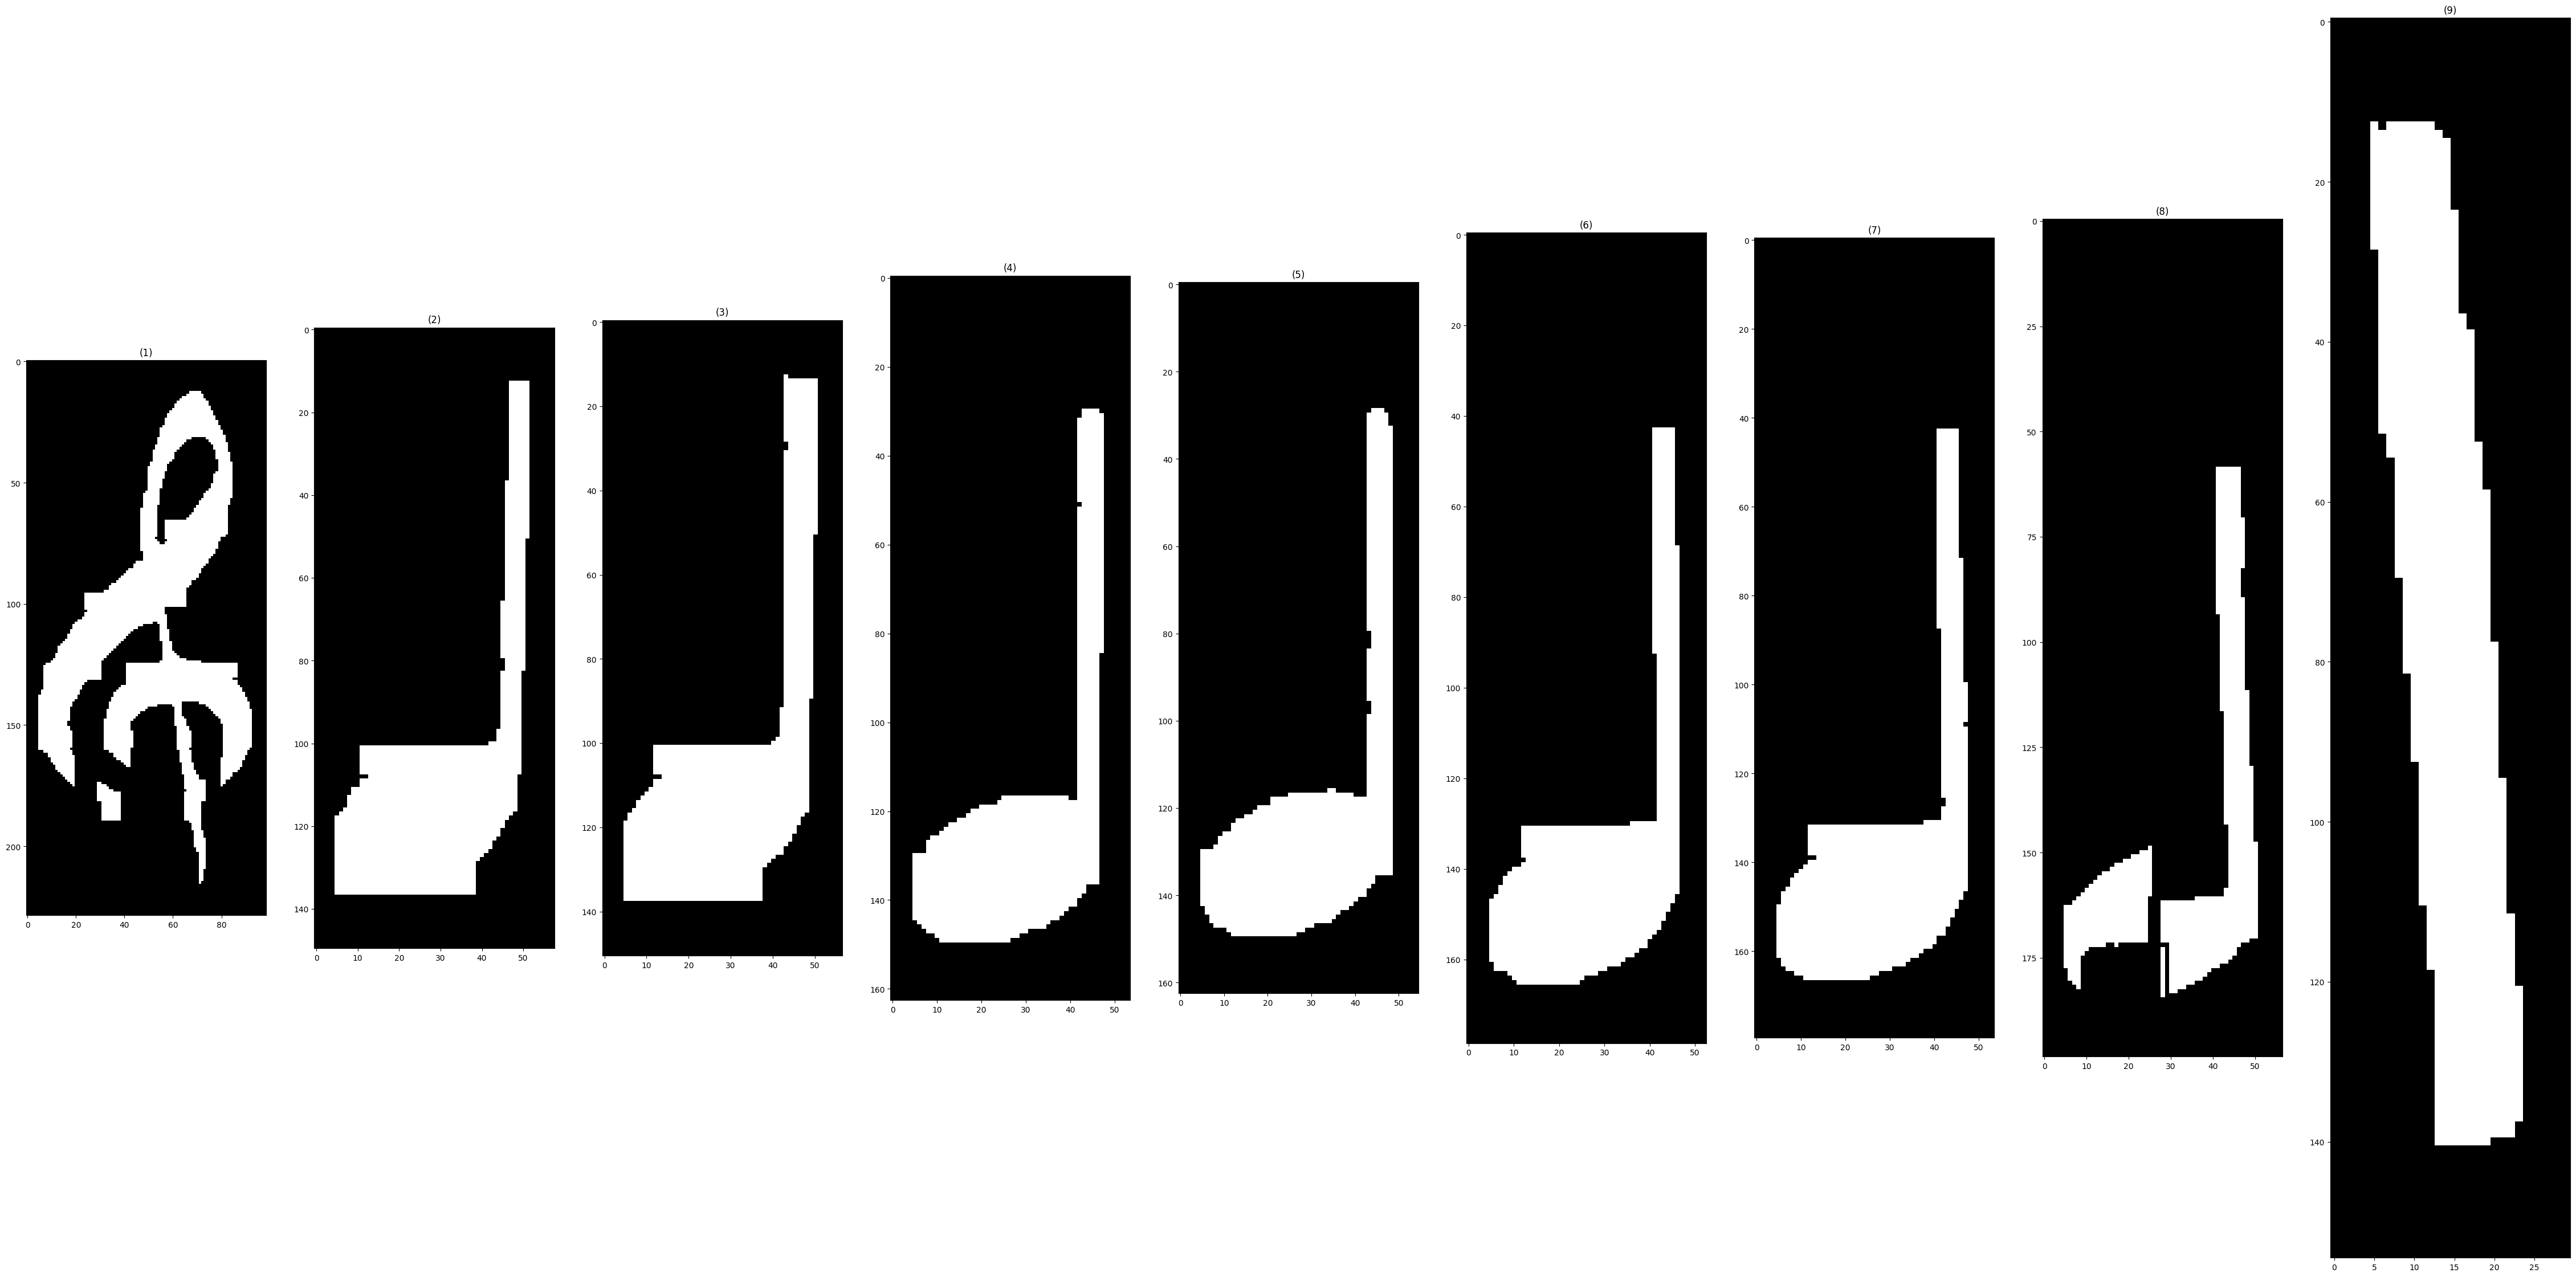

note[2][0] shape: (282, 86)
note[2][1] shape: (259, 101)
note[2][2] shape: (170, 59)
note[2][3] shape: (156, 55)
note[2][4] shape: (156, 54)
note[2][5] shape: (156, 20)
note[2][6] shape: (171, 56)
note[2][7] shape: (191, 57)
note[2][8] shape: (163, 31)
note[2][9] shape: (282, 54)


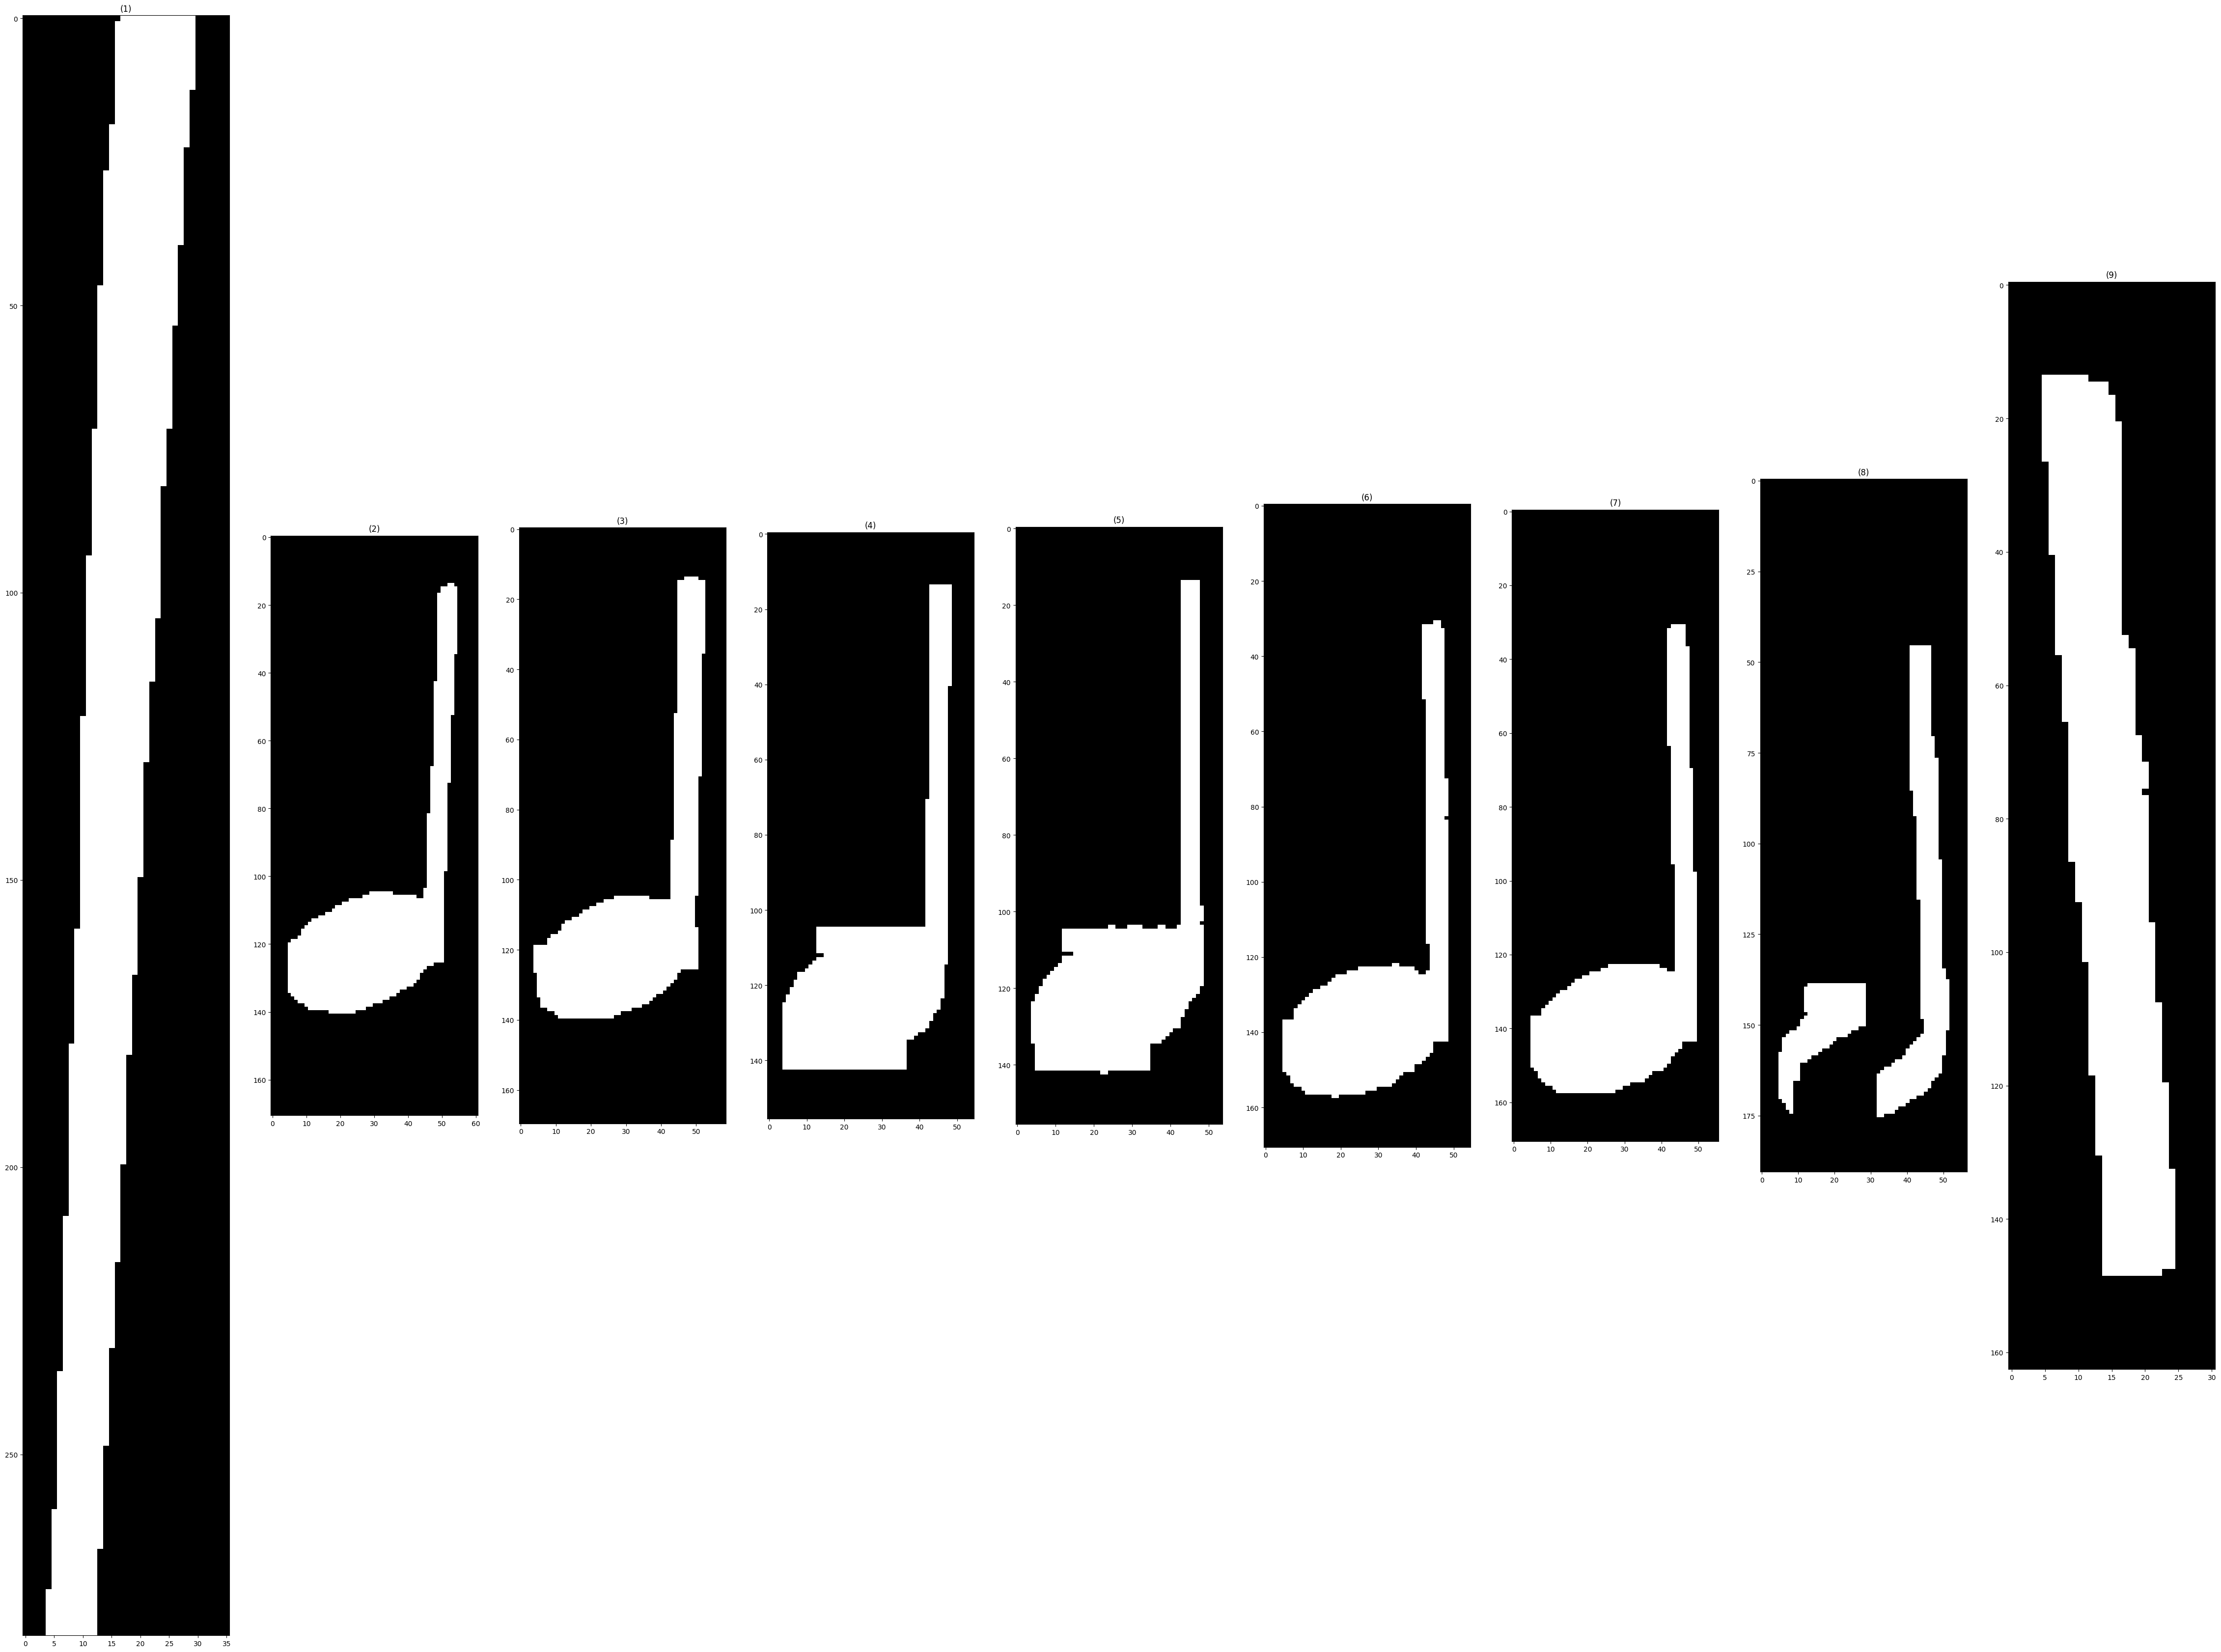

note[3][0] shape: (281, 62)
note[3][1] shape: (182, 61)
note[3][2] shape: (182, 62)
note[3][3] shape: (167, 57)
note[3][4] shape: (166, 57)
note[3][5] shape: (166, 20)
note[3][6] shape: (183, 58)
note[3][7] shape: (204, 59)
note[3][8] shape: (281, 56)


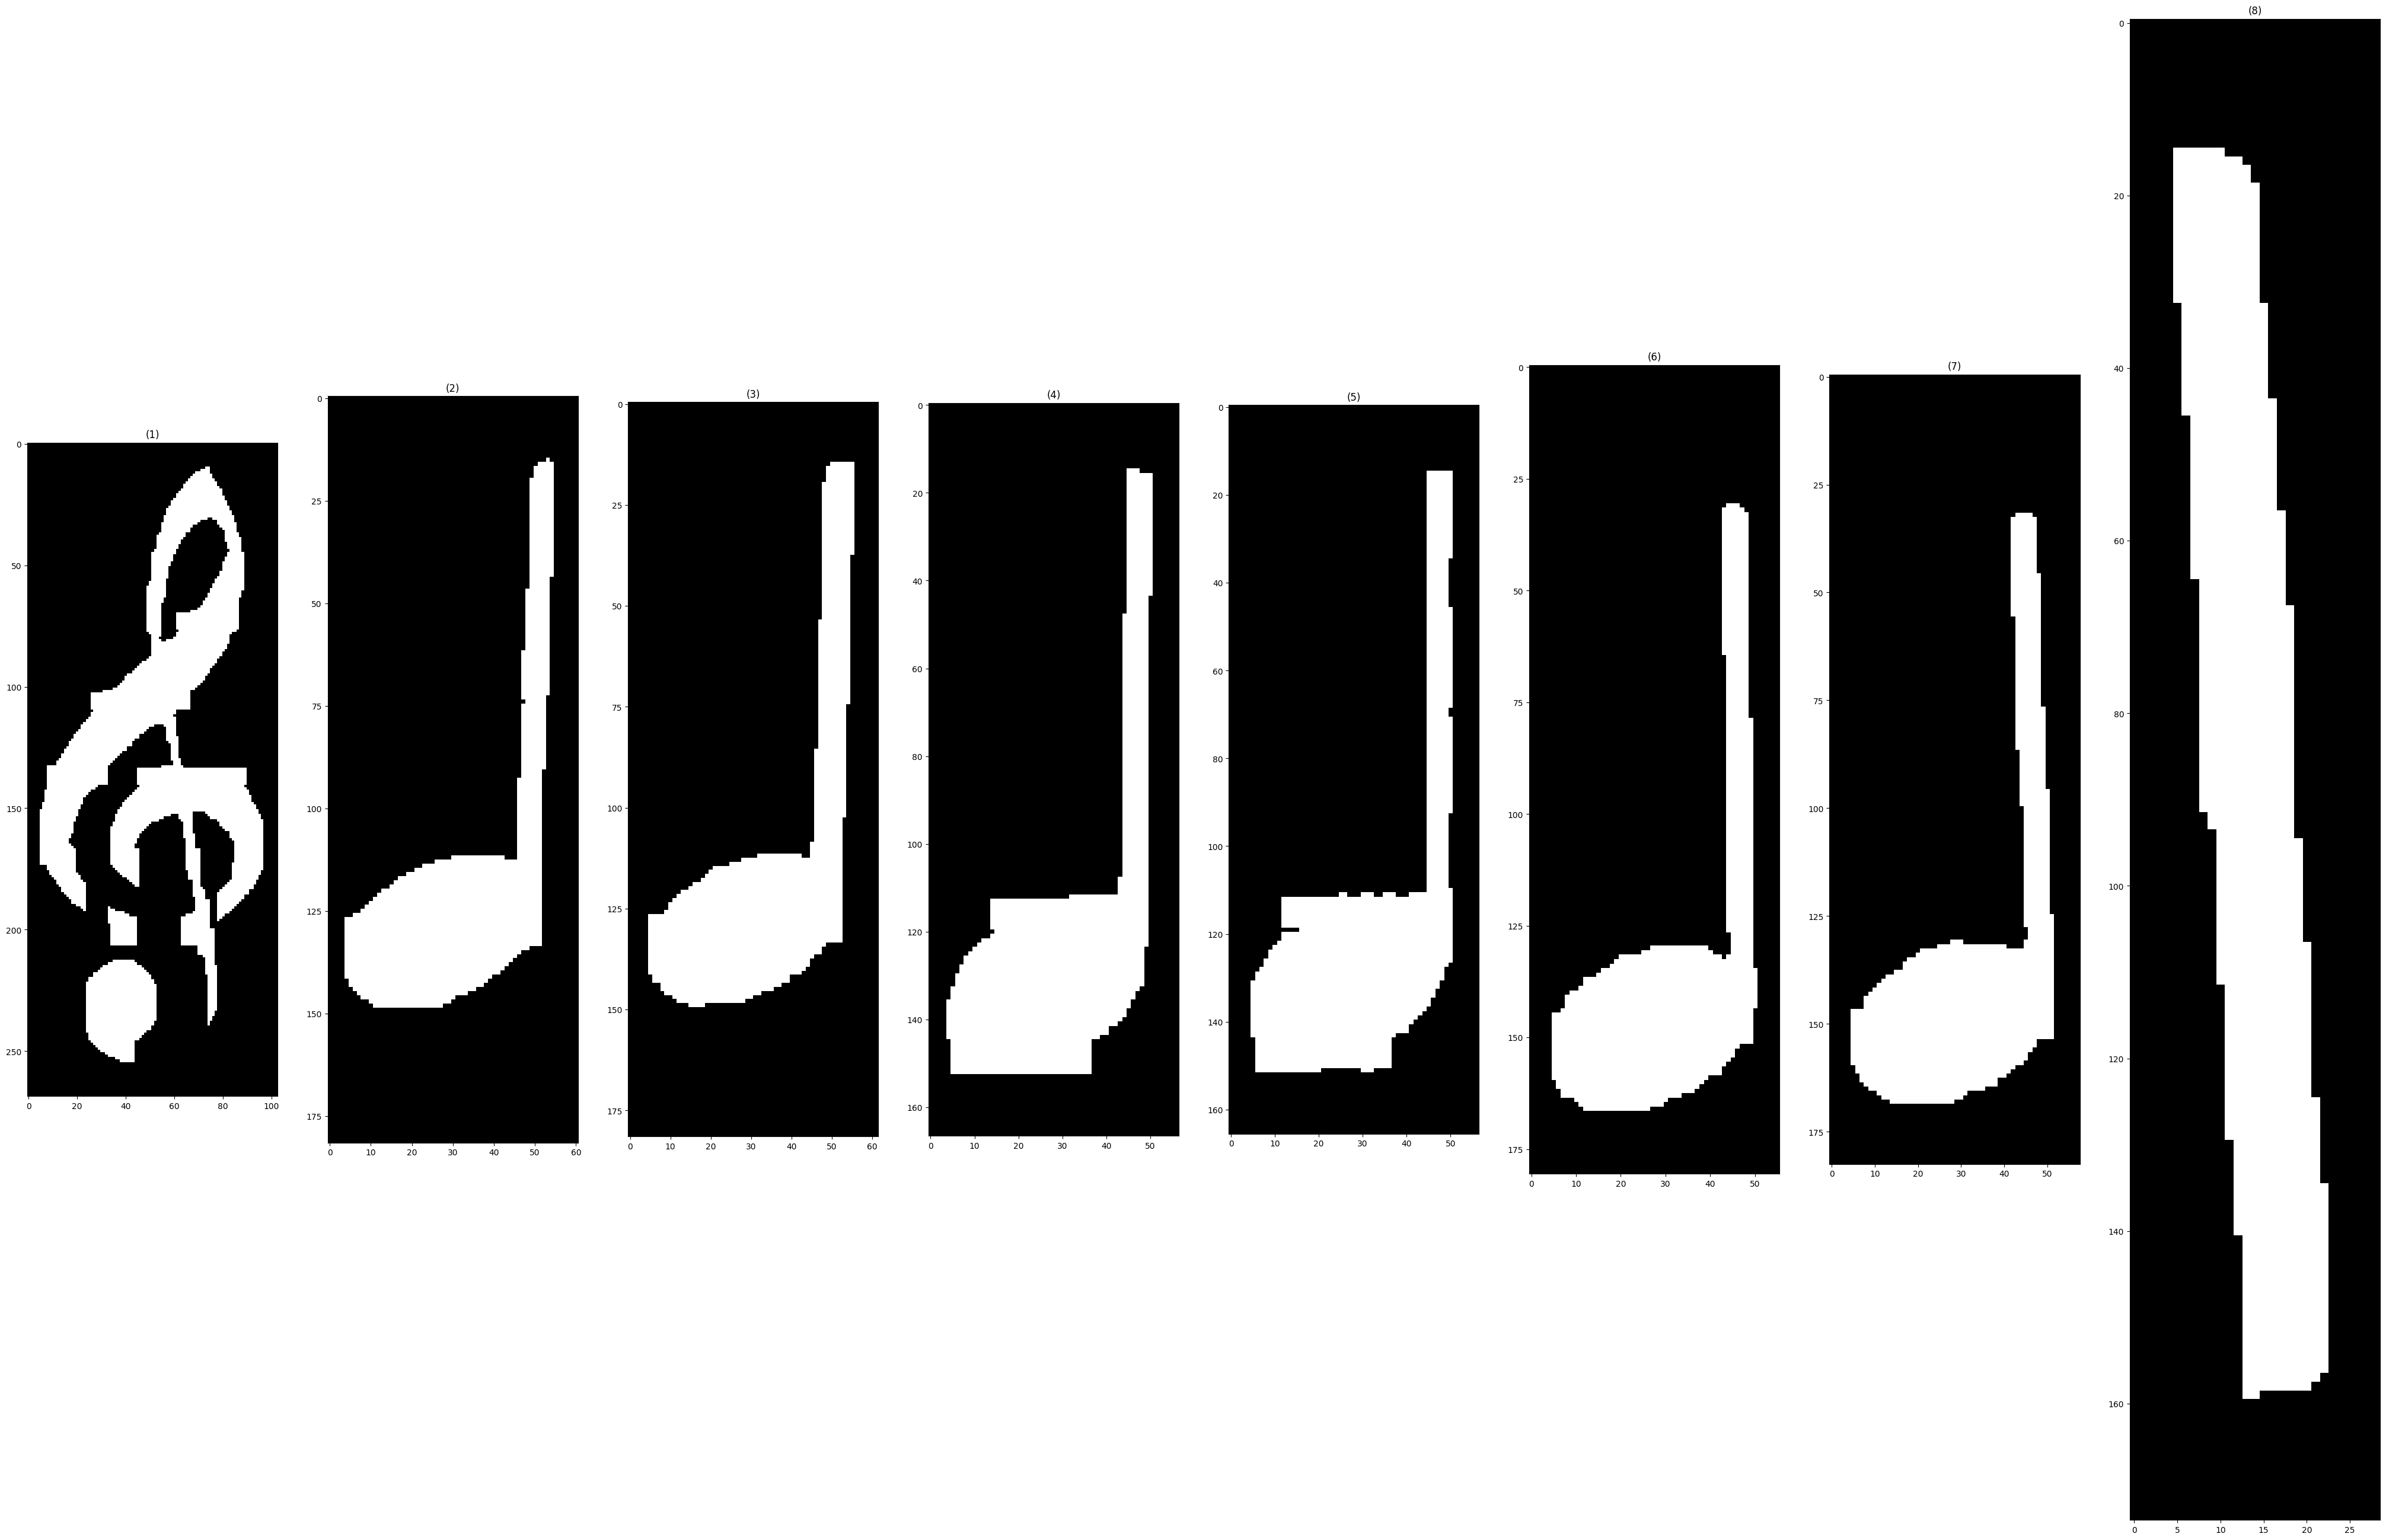

note[4][0] shape: (311, 50)
note[4][1] shape: (283, 104)
note[4][2] shape: (222, 61)
note[4][3] shape: (192, 59)
note[4][4] shape: (177, 21)
note[4][5] shape: (211, 58)
note[4][6] shape: (182, 28)


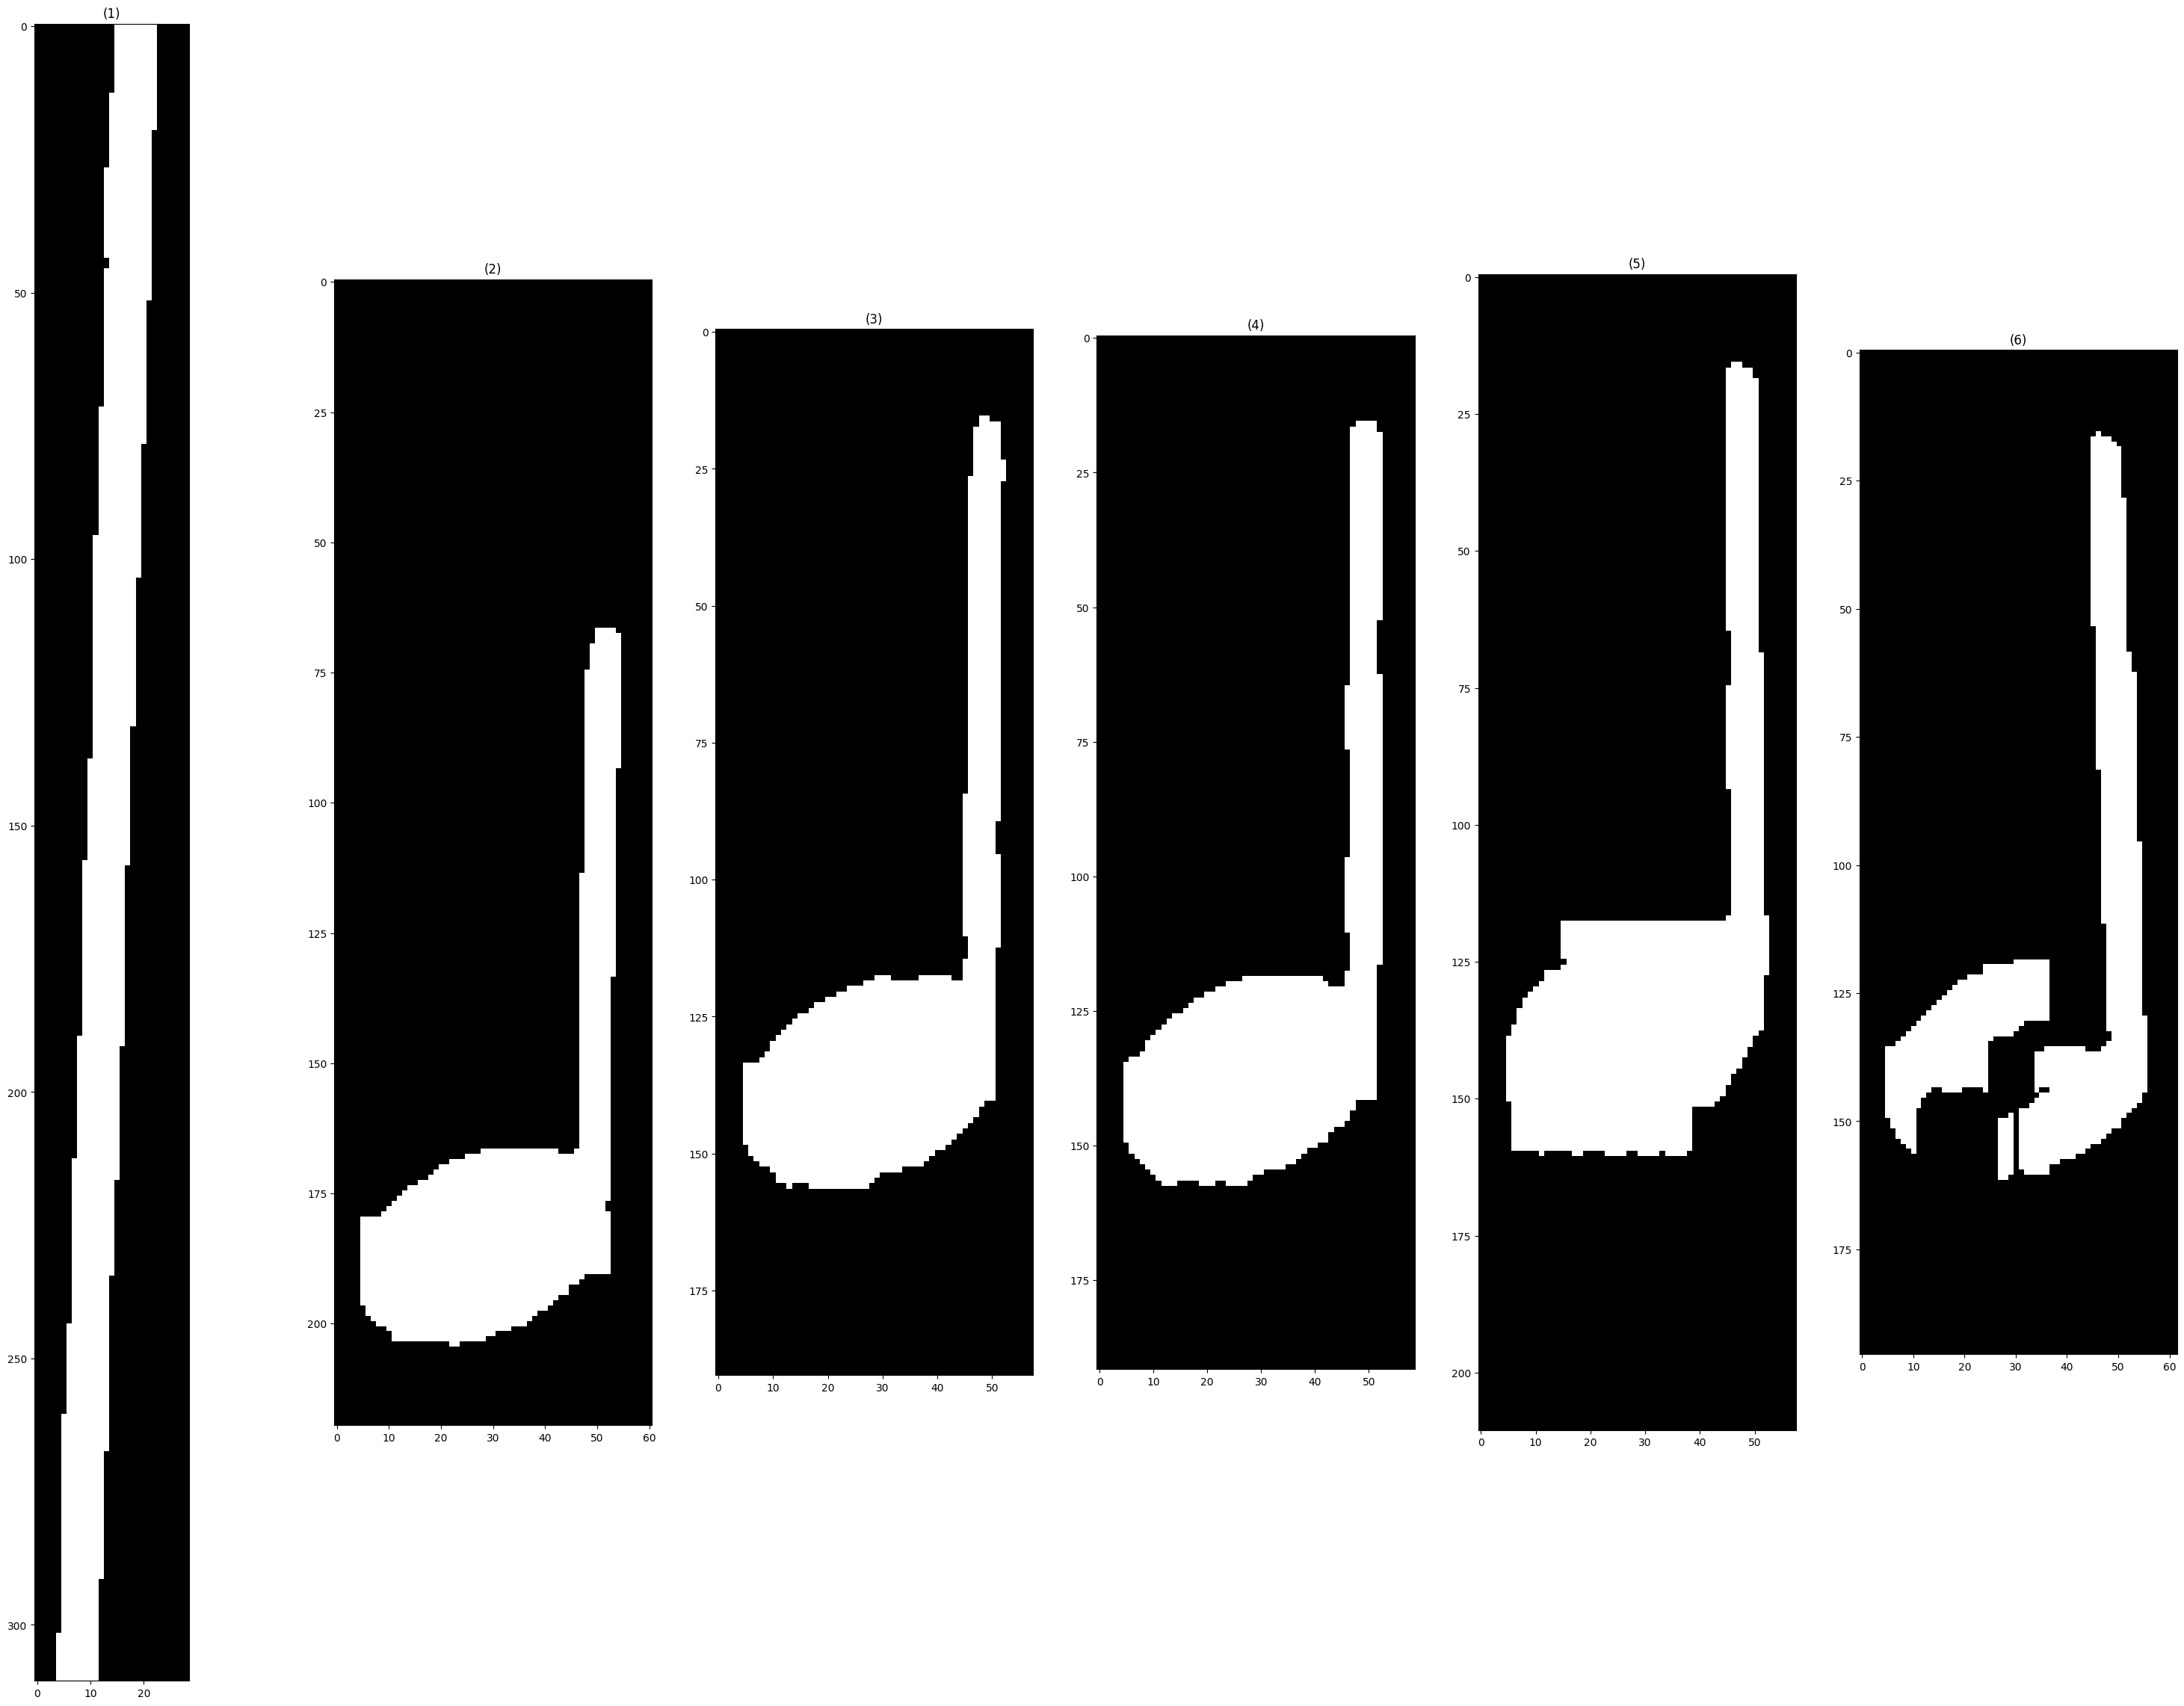

In [449]:
#Process each note to remove small lines remaining
for i,note in enumerate(all_notes):
    for j,notaia in enumerate(note):
        cleaned_note =remove_remaining_staff_notes(notaia, staff_height)
        all_notes[i][j]=dilate_vertically_with_staff_space(cleaned_note,1,staff_height)

print("-----------------")

# ...existing code...
for i, note in enumerate(all_notes):
    for j, notaia in enumerate(note):
        print(f"note[{i}][{j}] shape:", notaia.shape)
        # remove note with shape [0] for vertical height less than 160 pixels
        if notaia.shape[0] > 200:
            all_notes[i].pop(j)
            continue
        if notaia.shape[1] < 30:
            all_notes[i].pop(j)
            continue
        

    show_images(note)    

## Get rows in staves using voting mechanism with run length encoding

In [245]:
def get_lines_rows(img, T_LEN):
    row_start_freq = np.zeros((1, img.shape[0]+5))[0]
    row_starts = []

    for i in range(0, img.shape[1]):
        arr = runs_of_ones_array(img[:, i])
        k = 0
        j = 0
        while j < img.shape[0]:
            if img[j][i] == True:
                if arr[k] <= T_LEN + 2 and arr[k] >= T_LEN - 2:
                    row_start_freq[j] += 1
                    j += arr[k]-1
                else:
                    j += arr[k]

                k += 1
            j += 1

    max_freq_row_start = 0
    for r in row_start_freq:
        max_freq_row_start = max(max_freq_row_start, r)

    for i in range(len(row_start_freq)):
        # Approximately, if the row "i" is frequently treated as a starting of staffs with this ratio
        # by the most frequnt starting row, then consider it as a starting row of staffs.
        if row_start_freq[i]/max_freq_row_start >= 0.12:
            row_starts.append(i)
    return [row_starts, row_start_freq, max_freq_row_start]


In [246]:

def detect_notes(cleaned_stave, staff_lines, staff_space,staff_height):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (staff_space, staff_space)) # it get affected by the zoom in factor,range [(3,3) - (20,20)] ------> 
    processed_stave = cv2.morphologyEx(cleaned_stave.astype('uint8') * 255, cv2.MORPH_CLOSE, kernel)
    processed_stave = cv2.morphologyEx(processed_stave.astype('uint8') * 255, cv2.MORPH_OPEN, kernel)

    # Optional: Edge detection to highlight contours
    edges = cv2.Canny((processed_stave * 255).astype('uint8'), 50, 150)
    show_images([edges], ['Edges'])

    # Step 3: Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    show_images([cv2.drawContours(processed_stave, contours, -1, (0, 255, 0), 2)], ['Contours'])

    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    notes = []

    differences = [j - i for i, j in zip(staff_lines[:-1], staff_lines[1:])]
    average_distance_between_spaces = sum(differences) / len(differences)
    print("average dist: " + str(average_distance_between_spaces))
    
    staff_lines.append(staff_lines[-1]+int(average_distance_between_spaces))
    staff_lines.append(staff_lines[0]-int(average_distance_between_spaces))

    staff_lines = sorted(staff_lines)

    print(staff_lines)
    notes=[]
    for contour in contours:
        # Filter based on contour size (area) and aspect ratio
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 0

        # factor = 12 # this factor is for the value of zoom in
        print("area: " + str(area) + ", aspect ratio: " + str(aspect_ratio))
        if (staff_space * (1/2)) <= area <= (staff_space*(3/2)):  # Typical note head properties  area varies with the zoom in, range [300] --------->
            note_center = y + h // 2  # Vertical center of the note head

            print("note center: " + str(note_center) + ",x= " + str(x) + ",y1= " + str(y) +",y2= " + str(y+h))

            note_names_treble = ['C','D','E','F','G','A','B','C2','D2','E2','F2','G2','A2','B2']
            y1=y + int(average_distance_between_spaces/ 8)
            y2=y+h - int(average_distance_between_spaces/ 8)

            if  y2>staff_lines[-1] and y1<staff_lines[-1]:
                notes.append('C')
            elif y2<=staff_lines[-1] and y1>=staff_lines[-2]:
                notes.append('D')
            elif y2>staff_lines[-2] and y1<staff_lines[-2]:
                notes.append('E')
            elif y2<=staff_lines[-2] and y1>=staff_lines[-3]:
                notes.append('F')
            elif y2>staff_lines[-3] and y1<staff_lines[-3]:
                notes.append('G')
            elif y2<=staff_lines[-3] and y1>=staff_lines[-4]:
                notes.append('A')
            elif y2>staff_lines[-4] and y1<staff_lines[-4]:
                notes.append('B')
            elif y2<=staff_lines[-4] and y1>=staff_lines[-5]:
                notes.append('C2')
            elif y2>staff_lines[-5] and y1<staff_lines[-5]:
                notes.append('D2')
            elif y2<=staff_lines[-5] and y1>=staff_lines[-6]:
                notes.append('E2')
            elif y2>staff_lines[-6] and y1<staff_lines[-6]:
                notes.append('F2')
            elif y2<=staff_lines[-6] and y1>=staff_lines[-7]:
                notes.append('A2')
            elif y2>staff_lines[-7] and y1<staff_lines[-7]:
                notes.append('B2')
    return notes


[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258]


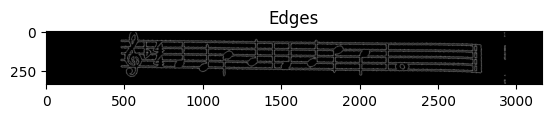

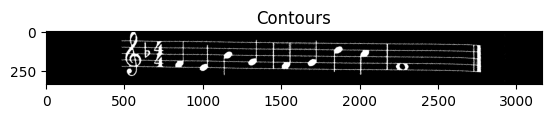

average dist: 1.0360824742268042
[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259]
area: 8.0, aspect rat

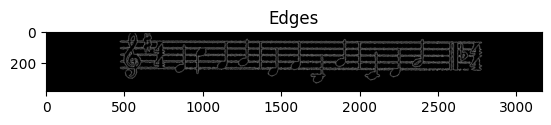

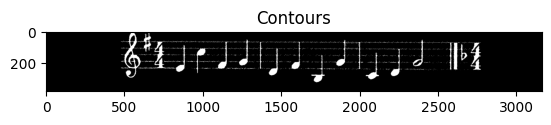

average dist: 1.9278350515463918
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
area: 3.5, aspect ratio: 4.384615384615385
area: 3.5, aspect ratio: 2.2222222222222223
area: 43.0, aspect ratio: 1.8214285714285714
area: 4.0, aspect ratio: 0.8064516129032258
area: 0.5, aspect ratio: 0.8571428571428571
note center: 147,x= 473,y1= 144,y2= 151
area: 0.0, aspect ratio: 1.5
area: 25.5, aspect ratio: 1.4883720930232558
area: 18.0, aspect ratio: 0.5930232558139535
area: 1.0, aspect ratio: 1.5
note center: 154,x= 476,y1= 153,y2= 155
area: 1.5, aspect ratio: 3.1428571428

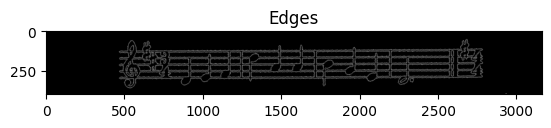

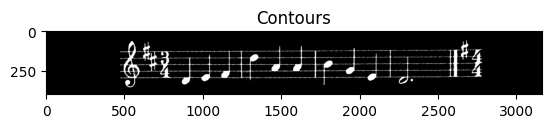

average dist: 1.825242718446602
[115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305]
area: 0.5, aspect ratio: 1.0
note center: 302,x= 465,y1= 298,y2= 306
area: 1.0, aspect ratio: 1.1
note center: 219,x= 465,y1= 214,y2= 224
area: 36.0, aspect ratio: 0.4782608695652174
area: 0.0, aspect ratio: 1.0
area: 9.5, aspect ratio: 0.675
area: 1.0, aspect ratio: 3.4285714285714284
note center: 179,x= 468,y1= 176,y2= 183
area: 3.5, aspect ratio: 6.142857142857143
area: 1.0, aspect ratio: 2.3333333333333335
note center: 210,x= 469

In [ ]:
for stave in staves:
    rows=get_lines_rows(stave,staff_height)
    print(rows[0])
    detected_notes=detect_notes(stave,rows[0],staff_space,staff_height)
    print(detected_notes)

Segment stave into notes

In [248]:
# def segment_staves(stave, original_stave,staff_space):    
#     """
#     Segments the musical notes from the stave by finding contours, drawing them, 
#     and extracting the notes as individual images.
    
#     Parameters:
#         stave (np.array): Binary processed stave image.
#         original_stave (np.array): Original stave image (grayscale or binary) to extract notes.
        
#     Returns:
#         list: A list of extracted musical note images.
#     """
#     # Ensure the stave is in uint8 format
#     if stave.dtype != np.uint8:
#         stave = (stave * 255).astype(np.uint8)

#     # Find contours of the dilated stave
#     contours, _ = cv2.findContours(stave, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Sort contours left to right (by x-coordinate)
#     contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

#     # Create a copy of the stave to draw contours on
#     stave_with_contours = cv2.cvtColor(stave, cv2.COLOR_GRAY2BGR)

#     # List to store extracted note images
#     notes = []

#     for contour in contours:
#         # Get the bounding rectangle (x, y, width, height) for each contour
#         x, y, w, h = cv2.boundingRect(contour)
        
#         # Draw the contour as a green rectangle on the stave copy
#         if h>staff_space*2:
#             cv2.rectangle(stave_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
#             # Extract the note from the original stave using the bounding box
#             note = original_stave[y:y+h, x:x+w]
#             notes.append(note)

#     # Show the stave with contours drawn
#     show_images([stave_with_contours], ["Stave with Contours"])

#     return notes


# def dilate_vertically_with_staff_space(stave, width, height):
#     """
#     Dilates the given stave vertically with a kernel size based on the staff space.
    
#     Parameters:
#         stave (np.array): Binary image of the stave.
#         staff_space (int): The space between staff lines, used for vertical dilation.
#         staff_height (int): The height of the staff lines.
        
#     Returns:
#         np.array: The vertically dilated stave.
#     """
#     # Ensure the stave is in uint8 format
#     if stave.dtype != np.uint8:
#         stave = (stave * 255).astype(np.uint8)  # Convert boolean to uint8 (255 for white, 0 for black)

#     # Create a vertical structuring element (kernel)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width, height))

#     # Apply vertical dilation
#     dilated_stave = cv2.dilate(stave, kernel, iterations=1)

#     return dilated_stave


# # Apply vertical dilation to the first processed stave
# # dilated_stave = dilate_vertically_with_staff_space(processed_staves[0], staff_space, staff_space + staff_height)
# dilated_staves=[]
# for i in range(len(processed_staves)):
#     dilated_stave = dilate_vertically_with_staff_space(processed_staves[i], staff_height * 3, staff_space + staff_height)
#     dilated_staves.append(dilated_stave)

# show_images(dilated_staves)

# notes=[]
# for i in range(len(dilated_staves)):
#     notes.append(segment_staves(dilated_staves[i], processed_staves[i],staff_space))    

# for i, note in enumerate(notes):
#     show_images(note)
# # # Show the original and dilated staves
# # show_images([processed_staves[0], dilated_stave], ["Original Processed Stave", "Vertically Dilated Stave"])

# # Segment the staves and extract musical notes
# # notes = segment_staves(dilated_stave, processed_staves[0])

# # Show each extracted note
# # for i, note in enumerate(notes):
# #     show_images([note], [f"Note {i+1}"])





remove_staff_lines_columnwise

In [249]:
# def remove_remaining_staff_notes(note, staff_height):
#     """
#     Removes staff lines from note by analyzing each column's run lengths.
#     If a column has a run of white pixels equal to the staff height, 
#     and the above and below columns have black runs, then this column is considered a staff line and removed.

#     Parameters:
#         note (np.array): Binary image of the note (white = 1, black = 0).
#         staff_height (int): The detected height of the staff lines.

#     Returns:
#         np.array: The processed note with staff lines removed.
#     """
#     processed_note = note.copy()
#     rows, cols = note.shape

#     for col in range(cols):
#         column_data = note[:, col]

#         bounded = np.hstack(([0], column_data, [0]))
#         difs = np.diff(bounded)
#         run_starts, = np.where(difs > 0)
#         run_ends, = np.where(difs < 0)

#         for i in range(len(run_starts)):
#             run_start = run_starts[i]
#             run_end = run_ends[i]
#             run_length = run_end - run_start


#             # Check if the run length is approximately equal to the staff height, the aproximation is based on the staff height
#             if run_length <= staff_height*2: # chcek in bigger images ----------------->
#                 # if column_data[run_start - staff_height] == 0 and column_data[run_end +  (staff_height if (run_end + staff_height) < len(column_data))] == 0: 
#                 if (run_start - staff_height >= 0 and column_data[run_start - staff_height] == 0) and (run_end + staff_height < len(column_data) and column_data[run_end + staff_height] == 0):
#                     processed_note[run_start : run_end , col] = 0

#     return processed_note

# for i,note in enumerate(notes):
#     for j,notaia in enumerate(note):
#         notes[i][j] =remove_remaining_staff_notes(notaia, staff_height)

# for i,note in enumerate(notes):
#     show_images(note)
# # Process a sample note from the extracted notes
# # processed_note = remove_remaining_staff_notes(notes[8], staff_height)
# # # processed_note= dilate_vertically_with_staff_space(processed_note, 1, staff_height)

# # # Show the original and processed notes
# # show_images([notes[8], processed_note], ["Original Note", "Processed Note",])

# # # Process a sample note from the extracted notes
# # processed_note = remove_remaining_staff_notes(notes[18], staff_height)
# # # processed_note= dilate_vertically_with_staff_space(processed_note, 1, staff_height * 2)


# # # Show the original and processed notes
# # show_images([notes[18], processed_note,], ["Original Note", "Processed Note"])

In [250]:
# # Function to detect bounding boxes for staves

# def getBoundedBoxes(image):
#     #get staff bounding boxes whether they are connected or not
#     img_height=image.shape[0]
#     img_width=image.shape[1]

#     dilation = binary_dilation(image, footprint=np.ones((10, 1)))
#     # show_images([dilation], ['Dilation'])

#     closing = remove_small_objects(dilation, 200, connectivity=8)
#     show_images([closing], ['Closing and Small Object Removal'])


#     img_without_begin=closing[:,int(img_height*0.2):img_height]
#     show_images([closing,img_without_begin])

#     img_without_begin = (img_without_begin * 255).astype('uint8')
#     output_image = (image * 255).astype('uint8')


#     contours_without_begin, _ = cv2.findContours(img_without_begin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours_with_begin, _ = cv2.findContours(output_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     img_without_begin = cv2.cvtColor(img_without_begin, cv2.COLOR_GRAY2BGR)
#     output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

#     #check if they are connected in the begining
#     staves=[]
#     correct_countours=contours_with_begin
#     is_correct_contours=False

#     if len(contours_with_begin) != len(contours_without_begin):
#         is_correct_contours=True
#         correct_countours=contours_without_begin
        
#     for contour in correct_countours:
#         x, y, w, h = cv2.boundingRect(contour)
#         # cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
#         if(w>1.1*h and w*h > 50):
#             start_x = x
#             end_x = img_width
#             # print("width",img_width)
#             # print("final_image shape",image.shape)
#             if(is_correct_contours):
#                 start_x=0
#             stave = output_image[y:y + h, start_x:end_x]
#             # print("Width",w)
#             # print("Height",h)
#             staves.append(stave)
#             show_images([stave], ["Stave222"])

#     return staves

# staves2= getBoundedBoxes(final_image)


In [251]:
# def remove_staff_lines(staves):
#     cleaned_staves = []
#     staff_lines_positions = []

#     for stave in staves:
#         # Invert stave to make lines white on black background
#         stave = 255 - stave
        
#         # Edge detection for the stave
#         edges = cv2.Canny(stave, 50, 150, apertureSize=3)
#         show_images([edges], ['Edges'])

#         # Detect lines using Hough Transform
#         lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
        
#         if lines is not None:
#             line_y_positions = []
#             for line in lines:
#                 x1, y1, x2, y2 = line[0]
#                 if abs(y2 - y1) < 5:  # Ensure the line is horizontal
#                     line_y_positions.append((y1 + y2) // 2)  # Average y-coordinate for the line

#             # Get 5 staff line positions by finding the most frequent y-coordinates
#             line_y_positions = sorted(line_y_positions)
#             staff_lines = []
#             for y in line_y_positions:
#                 if not staff_lines or abs(y - staff_lines[-1]) > 5:  # Avoid duplicates
#                     staff_lines.append(y)
#             staff_lines_positions.append(staff_lines[:5])  # Ensure only 5 lines are kept
#         else:
#             staff_lines_positions.append([])  # No lines detected

#         stave_ratio = stave.shape[1]/stave.shape[0]
#         print("Stave ratio: "+str(stave_ratio))


#         # Remove the detected staff lines from the stave image
#         horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1)) # x value of MORPH_RECT range [15-100] it depend on the zoom in of ------>
#         detected_lines = cv2.morphologyEx(stave, cv2.MORPH_OPEN, horizontal_kernel)
        
#         show_images([detected_lines])

#         cleaned_image = stave - detected_lines
#         cleaned_image = cleaned_image > 0
#         dilated = binary_dilation(cleaned_image, footprint=np.ones((8, 1))) # 1st dilation depeneds on the zoom in , range [2-7] ------>

#         cleaned_staves.append(dilated)
#         # show_images([dilated], ['Cleaned Stave'])

#     return cleaned_staves, staff_lines_positions

# cleaned_staves, staff_lines_positions = remove_staff_lines(staves)
# show_images(cleaned_staves)
# print(staff_lines_positions)

In [252]:

# def detect_notes(cleaned_stave, staff_lines):
#     # Step 1: Remove staff lines
#     # stave_no_lines = cleaned_stave.copy()
#     # for line in staff_lines:
#     #     stave_no_lines[line - 2:line + 2, :] = 0  # Mask out staff lines (2-pixel width)
#     # Step 2: Use morphological operations to isolate note heads

#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25)) # it get affected by the zoom in factor,range [(3,3) - (20,20)] ------> 
#     processed_stave = cv2.morphologyEx(cleaned_stave.astype('uint8') * 255, cv2.MORPH_CLOSE, kernel)
#     processed_stave = cv2.morphologyEx(processed_stave.astype('uint8') * 255, cv2.MORPH_OPEN, kernel)

#     # Optional: Edge detection to highlight contours
#     edges = cv2.Canny((processed_stave * 255).astype('uint8'), 50, 150)
#     show_images([edges], ['Edges'])

#     # Step 3: Find contours
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     show_images([cv2.drawContours(processed_stave, contours, -1, (0, 255, 0), 2)], ['Contours'])

#     contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

#     notes = []

#     differences = [j - i for i, j in zip(staff_lines[:-1], staff_lines[1:])]
#     average_distance_between_spaces = sum(differences) / len(differences)
#     print("average dist: " + str(average_distance_between_spaces))
    
#     staff_lines.append(staff_lines[-1]+int(average_distance_between_spaces))
#     staff_lines.append(staff_lines[0]-int(average_distance_between_spaces))

#     staff_lines = sorted(staff_lines)

#     print(staff_lines)
#     notes=[]
#     for contour in contours:
#         # Filter based on contour size (area) and aspect ratio
#         area = cv2.contourArea(contour)
#         x, y, w, h = cv2.boundingRect(contour)
#         aspect_ratio = w / h if h > 0 else 0

#         factor = 12 # this factor is for the value of zoom in
#         print("area: " + str(area) + ", aspect ratio: " + str(aspect_ratio))
#         if (10 * factor) < area < (300 * factor) and 0.7 < aspect_ratio < 1.3:  # Typical note head properties  area varies with the zoom in, range [300] --------->
#             note_center = y + h // 2  # Vertical center of the note head

#             print("note center: " + str(note_center) + ",x= " + str(x) + ",y1= " + str(y) +",y2= " + str(y+h))

#             note_names_treble = ['C','D','E','F','G','A','B','C2','D2','E2','F2','G2','A2','B2']
#             y1=y + int(average_distance_between_spaces/ 8)
#             y2=y+h - int(average_distance_between_spaces/ 8)

#             if  y2>staff_lines[-1] and y1<staff_lines[-1]:
#                 notes.append('C')
#             elif y2<=staff_lines[-1] and y1>=staff_lines[-2]:
#                 notes.append('D')
#             elif y2>staff_lines[-2] and y1<staff_lines[-2]:
#                 notes.append('E')
#             elif y2<=staff_lines[-2] and y1>=staff_lines[-3]:
#                 notes.append('F')
#             elif y2>staff_lines[-3] and y1<staff_lines[-3]:
#                 notes.append('G')
#             elif y2<=staff_lines[-3] and y1>=staff_lines[-4]:
#                 notes.append('A')
#             elif y2>staff_lines[-4] and y1<staff_lines[-4]:
#                 notes.append('B')
#             elif y2<=staff_lines[-4] and y1>=staff_lines[-5]:
#                 notes.append('C2')
#             elif y2>staff_lines[-5] and y1<staff_lines[-5]:
#                 notes.append('D2')
#             elif y2<=staff_lines[-5] and y1>=staff_lines[-6]:
#                 notes.append('E2')
#             elif y2>staff_lines[-6] and y1<staff_lines[-6]:
#                 notes.append('F2')
#             elif y2<=staff_lines[-6] and y1>=staff_lines[-7]:
#                 notes.append('A2')
#             elif y2>staff_lines[-7] and y1<staff_lines[-7]:
#                 notes.append('B2')

    
#     return notes


In [253]:
# # Function to map note positions to musical notes
# def map_positions_to_notes(positions, clef='treble'):
#     note_names_treble = ['F', 'E', 'D', 'C', 'B', 'A', 'G']
#     note_names_bass = ['A', 'G', 'F', 'E', 'D', 'C', 'B']
    
#     note_names = note_names_treble if clef == 'treble' else note_names_bass
#     mapped_notes = [note_names[pos % len(note_names)] for pos in positions if pos >= 0]
#     return mapped_notes

# # Main processing
# # final_image = cv2.imread('sheet_music.png', cv2.IMREAD_GRAYSCALE)  # Load your image here
# # final_image = final_image < 128  # Binarize the image
# # show_images([final_image], ["Final Image"])

# # staves = getBoundedBoxes(final_image)
# # cleaned_staves, staff_lines_positions = remove_staff_lines(staves)

# print(staff_lines_positions)

# for i, (stave, staff_lines) in enumerate(zip(cleaned_staves, staff_lines_positions)):
#     notes = detect_notes(stave, staff_lines)
#     print(f"Detected Notes in Stave {i + 1}: {notes}")
